In [4]:
import pandas as pd
df_3 = pd.read_csv('/Users/longderek/Documents/ICML/graph-kernel-convergence/results/diffusion_sym_d3.csv')
df_3

,N,p_T,mse_K_inner,mse_g_sv
0,5,0.05000,0.009609,1.725140e-03
1,15,0.05000,0.000918,5.053762e-06
2,25,0.00500,0.000404,3.852241e-07
3,35,0.00500,0.000251,7.718571e-08
4,45,0.00100,0.000191,2.541079e-08
5,55,0.00100,0.000155,1.259150e-08
6,65,0.00100,0.000132,8.223702e-09
7,75,0.00050,0.000116,5.655805e-09
8,85,0.00050,0.000106,4.497944e-09
9,95,0.00050,0.000099,4.033458e-09


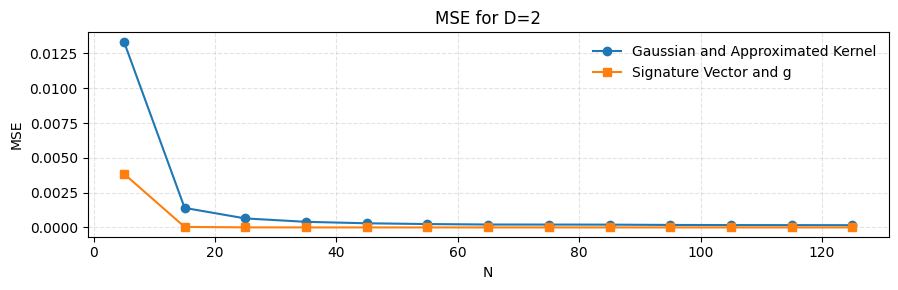

In [30]:
# pip install pandas matplotlib
import io
import pandas as pd
import matplotlib.pyplot as plt

# Load data
D = 2
df = pd.read_csv(f'/Users/longderek/Documents/ICML/graph-kernel-convergence/results/diffusion_sym_d{D}.csv')
df = df[:]
df = df.sort_values("N")

plt.figure(figsize=(9, 3))
plt.plot(df["N"], df["mse_K_inner"], marker="o", linewidth=1.5, label="Gaussian and Approximated Kernel")
plt.plot(df["N"], df["mse_g_sv"], marker="s", linewidth=1.5, label="Signature Vector and g")
# ax1.set_yscale("log")
plt.ylabel("MSE")
plt.xlabel("N")
plt.grid(True, which="both", linestyle="--", alpha=0.35)
plt.legend(loc="best", frameon=False)
plt.title(f"MSE for D={D}")
plt.tight_layout()
# Uncomment to save instead of (or in addition to) showing:
# plt.savefig("mse_and_pT_vs_N.png", dpi=300, bbox_inches="tight")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def _neighbors(r, c, n):
    nbrs = []
    if r > 0: nbrs.append((r-1, c))
    if r < n-1: nbrs.append((r+1, c))
    if c > 0: nbrs.append((r, c-1))
    if c < n-1: nbrs.append((r, c+1))
    return nbrs

def neighbors(r, c, n):
    nbrs = []
    nbrs.append(((r-1) % n, c % n))
    nbrs.append(((r+1) % n, c % n))
    nbrs.append((r % n, (c-1) % n))
    nbrs.append((r % n, (c+1) % n))
    return nbrs

def generate_signature_vector(n=25, source=(12, 12), num_walks=1000, p_term=0.1, gamma=0.9, print_progress=False):
    visits = np.zeros((n, n), dtype=np.float64)
    sr, sc = source
    rng = np.random.default_rng()

    for i in range(num_walks):
        if print_progress and i % (num_walks // 10) == 0:
            print(f"Walk {i}/{num_walks}")
        r, c = sr, sc
        load = 1.0              
        visits[r, c] += load       
        while True:
            if rng.random() <= p_term:
                break
            nbrs = neighbors(r, c, n)
            deg_v = len(nbrs)
            w_r, w_c = nbrs[rng.integers(deg_v)]
            deg_w = len(neighbors(w_r, w_c, n))
            p = 1.0 / deg_v
            u_vw = gamma / np.sqrt(deg_v * deg_w) 
            load *= u_vw / (p * (1.0 - p_term))
            r, c = w_r, w_c
            visits[r, c] += load

    return visits / num_walks

def plot_signature_vector(signature, n=25, p_term=0.1, source=(12, 12), vmin=None, vmax=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(signature, origin="lower", vmin=vmin, vmax=vmax)
    plt.title(f"GRF-Style Signature Heatmap (n={n}, p_term={p_term}, source={source})")
    plt.colorbar(label="signature value")
    plt.tight_layout()

def plot_marginalized(signature, vmin=None, vmax=None, title=None, savepath=None):
    plt.figure(figsize=(6, 4))
    plt.plot(signature.sum(axis=0), label="column marginal")
    plt.plot(signature.sum(axis=1), label="row marginal")
    plt.title("Marginalized Signature Distribution")
    plt.xlabel("index")
    plt.ylabel("marginal value")
    plt.ylim(vmin, vmax)
    plt.legend()
    plt.tight_layout()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")

def plot_all_marginalized(signatures, labels, vmin=None, vmax=None, title=None, savepath=None):
    plt.figure(figsize=(6, 4))
    colors = plt.cm.viridis(np.linspace(0, 1, len(signatures)))
    for signature, label in zip(signatures, labels):
        plt.plot(signature.sum(axis=0), label=f"{label} column marginal", color=colors[labels.index(label)])
        plt.plot(signature.sum(axis=1), label=f"{label} row marginal", color=colors[labels.index(label)], linestyle='--')
    plt.title("Marginalized Signature Distributions")
    plt.xlabel("index")
    plt.ylabel("marginal value")
    plt.ylim(vmin, vmax)
    plt.legend()
    plt.tight_layout()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")

In [ ]:
n = 25
p_term = 0.0001
num_walks = 10000
source = (n // 2, n // 2)
gamma = 0.999
signature_fine = generate_signature_vector(n=n, source=source, num_walks=num_walks, p_term=p_term, gamma=gamma)
plot_signature_vector(signature_fine, n=n, p_term=p_term, source=source)

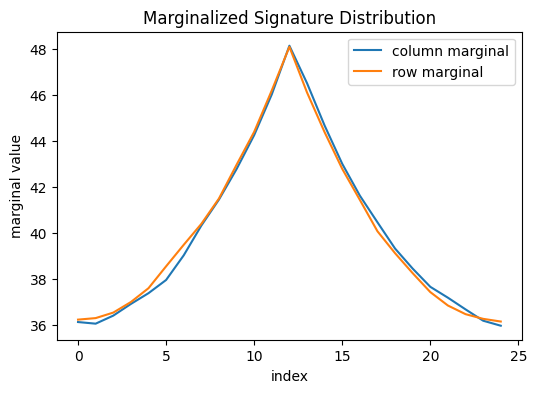

In [3]:
plot_marginalized(signature_fine)

In [19]:
n = 25
p_term = 0.01
num_walks = 500
source = (n // 2, n // 2)
gamma = 0.9
signature_vectors = [[[] for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(n):
        signature_vectors[i][j] = generate_signature_vector(n=n, source=(i, j), num_walks=num_walks, p_term=p_term, gamma=gamma)

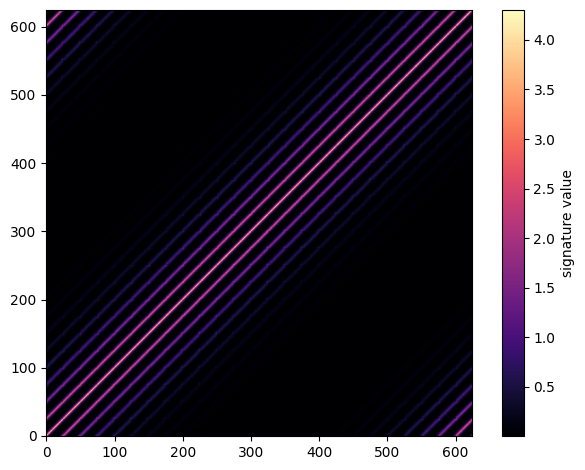

In [20]:
kernel_matrix = np.zeros((n*n, n*n), dtype=np.float64)
for i in range(n):
    for i_ in range(n):
        for j in range(n):
            for j_ in range(n):
                kernel_matrix[i*n + i_, j*n + j_] = np.multiply(signature_vectors[j][j_], signature_vectors[i][i_]).sum()
plt.set_cmap("magma")
plt.imshow(kernel_matrix, origin="lower")
plt.colorbar(label="signature value")
plt.tight_layout()

Text(0.5, 1.0, 'Row reshaped back to 2-D grid')

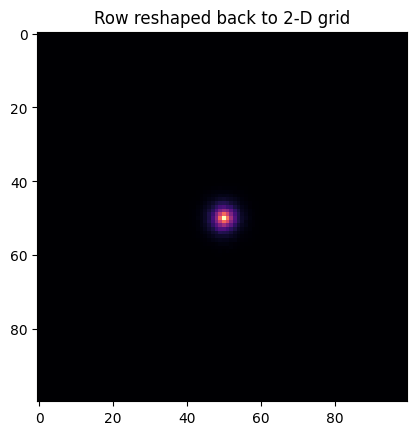

In [22]:
i0 = (n//2)*n + (n//2)      # center node index
row = kernel_matrix[i0, :].reshape(n, n)
plt.imshow(row)
plt.title("Row reshaped back to 2-D grid")

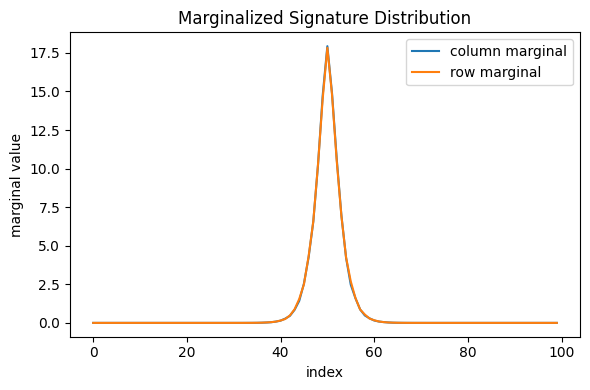

In [25]:
plot_marginalized(row)

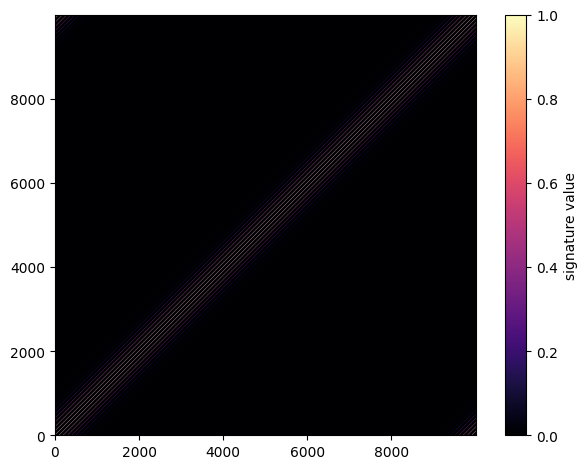

In [5]:
plt.set_cmap("magma")
plt.imshow(kernel_matrix, origin="lower", vmax=1.)
plt.colorbar(label="signature value")
plt.tight_layout()

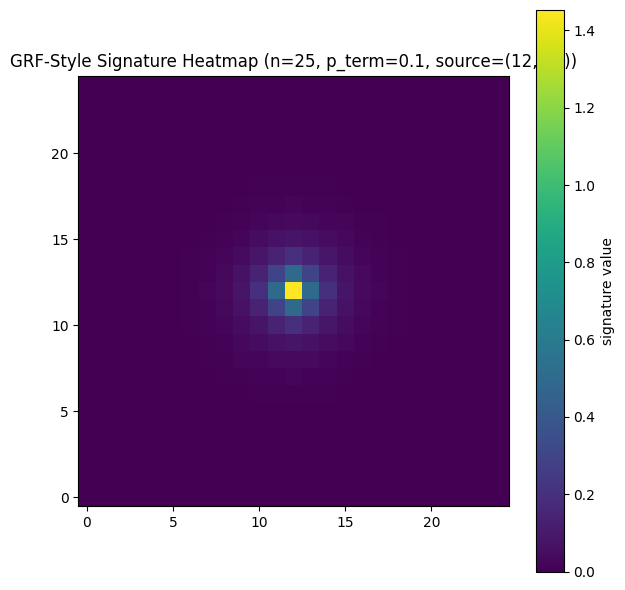

In [22]:
n = 25
p_term = 0.1
num_walks = 100000
source = (n // 2, n // 2)
gamma = 0.9
signature = generate_signature_vector(n=n, source=source, num_walks=num_walks, p_term=p_term, gamma=gamma)
plot_signature_vector(signature, n=n, p_term=p_term, source=source)

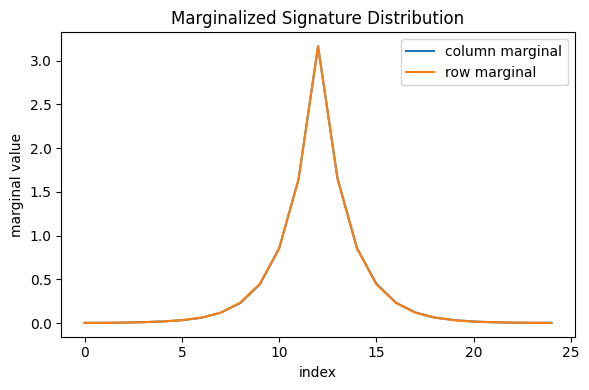

In [23]:
plot_marginalized(signature)

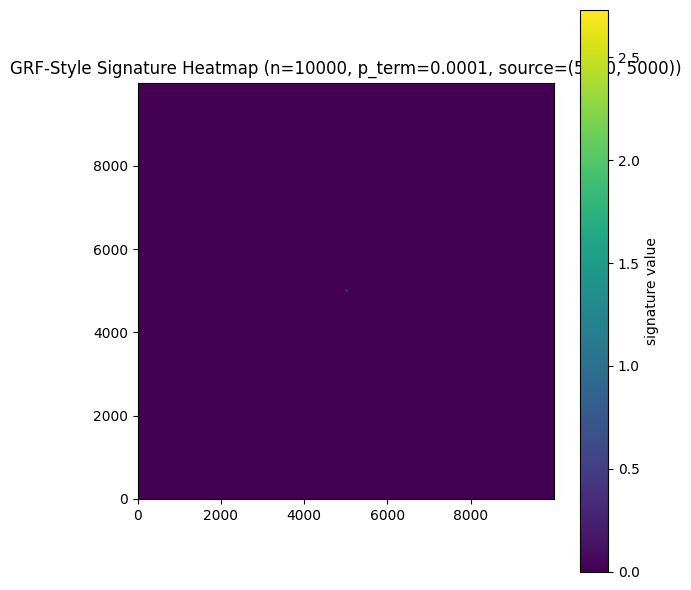

In [ ]:
n = 10000
p_term = 0.0001
num_walks = 1000
source = (n // 2, n // 2)
gamma = 0.999
signature = generate_signature_vector(n=n, source=source, num_walks=num_walks, p_term=p_term, gamma=gamma)
plot_signature_vector(signature, n=n, p_term=p_term, source=source, vmin=0., vmax=None)

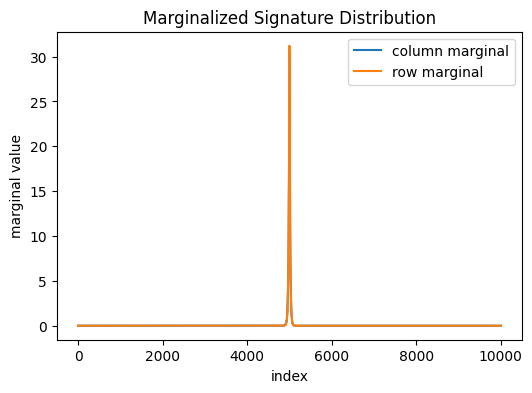

In [4]:
plot_marginalized(signature)

In [6]:
n = 25
p_term = 0.01
num_walks = 1000
source = (n // 2, n // 2)
gamma = 0.9

signature_vector_matrix = [[np.zeros((n, n), dtype=np.float64) for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(n):
        signature_vector_matrix[i][j] = generate_signature_vector(n=n, source=(i, j), num_walks=num_walks, p_term=p_term, gamma=gamma)

print("Sum of signature matrix vectors")
total_signature = np.sum(signature_vector_matrix, axis=(0, 1))

Sum of signature matrix vectors


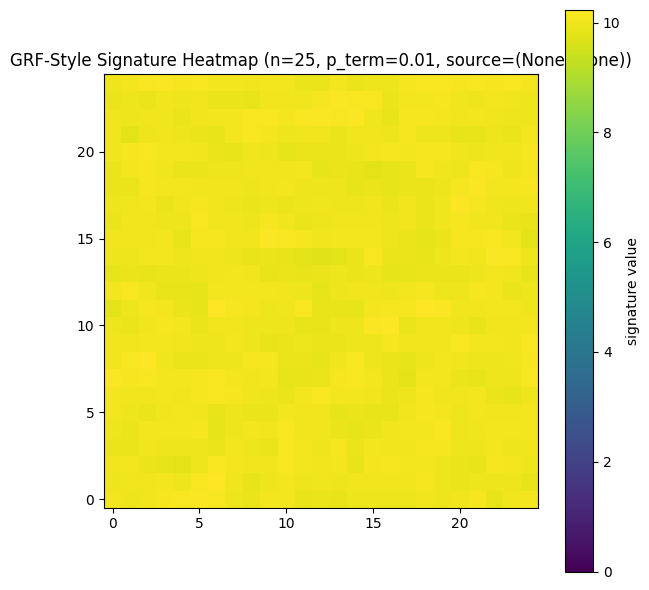

In [14]:
plot_signature_vector(total_signature, n=n, p_term=p_term, source=(None, None), vmin=0.)

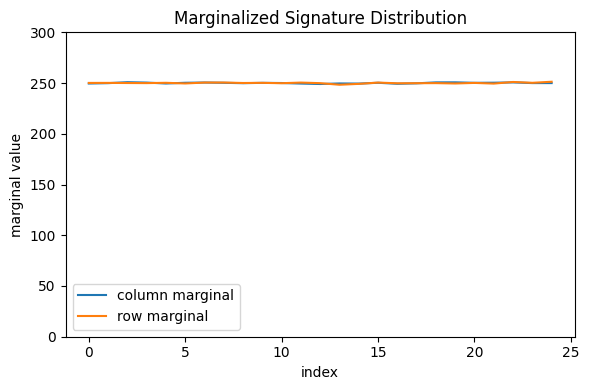

In [12]:
plot_marginalized(total_signature, vmin=0., vmax=300)

Running diffusion → Gaussian...


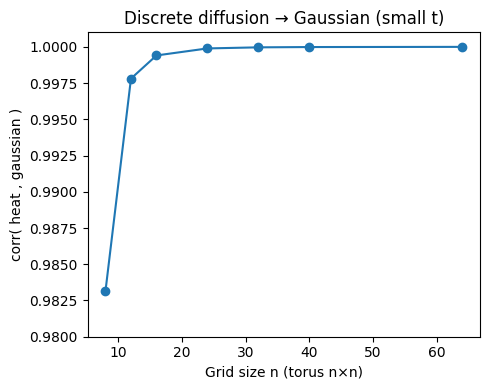

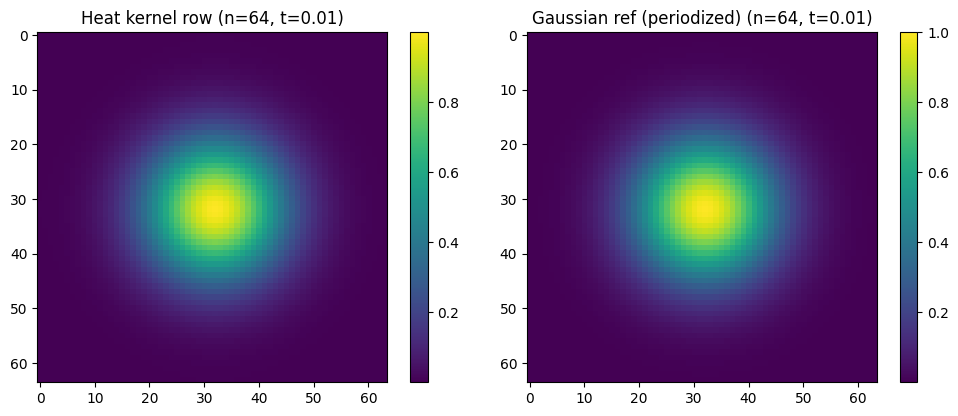

n=  8  corr(heat,gaussian)=0.983156
n= 12  corr(heat,gaussian)=0.997807
n= 16  corr(heat,gaussian)=0.999405
n= 24  corr(heat,gaussian)=0.999890
n= 32  corr(heat,gaussian)=0.999965
n= 40  corr(heat,gaussian)=0.999985
n= 64  corr(heat,gaussian)=0.999997

Running resolvent (discrete → continuum)...


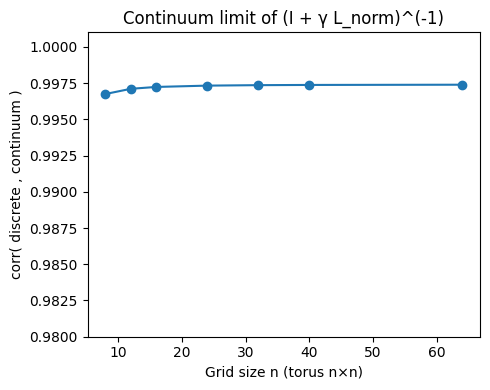

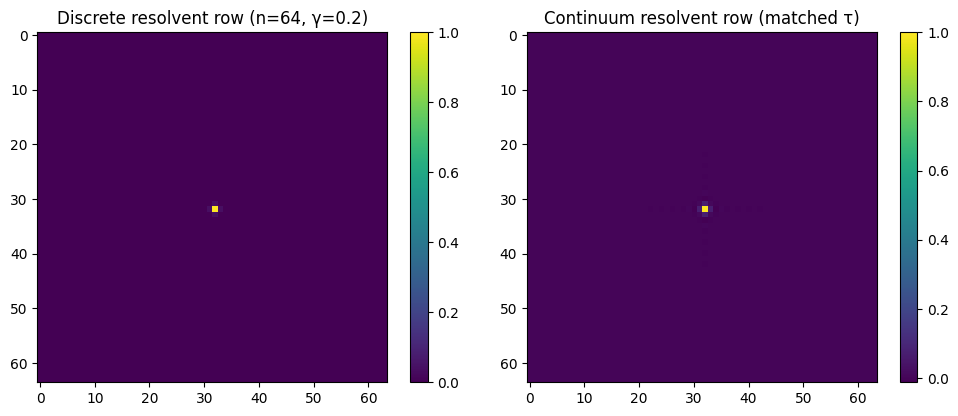

n=  8  corr(discrete,continuum)=0.996746
n= 12  corr(discrete,continuum)=0.997106
n= 16  corr(discrete,continuum)=0.997233
n= 24  corr(discrete,continuum)=0.997324
n= 32  corr(discrete,continuum)=0.997356
n= 40  corr(discrete,continuum)=0.997370
n= 64  corr(discrete,continuum)=0.997386

Running GRF estimator → discrete resolvent (fixed n=24)...


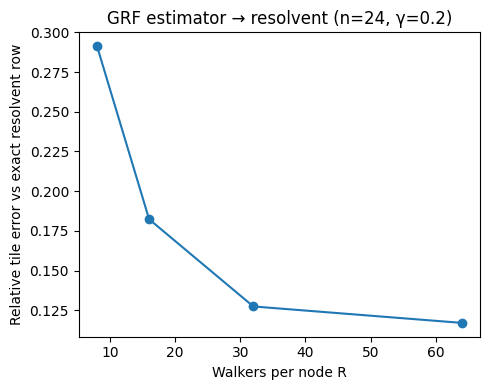

R=  8  rel_tile_err=0.2913
R= 16  rel_tile_err=0.1823
R= 32  rel_tile_err=0.1274
R= 64  rel_tile_err=0.1170


In [95]:
# limit_experiments.py
# ------------------------------------------------------------
# Shows two convergence stories on 2-D torus (periodic grid):
# 1) Discrete diffusion kernel e^{-t L / h^2} → (periodized) Gaussian
# 2) GRF (random-walk) → resolvent (I + γ L_norm)^{-1}, and
#    discrete resolvent → continuum resolvent under τ = γ h^2 / 4
#
# Deps: numpy, matplotlib
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt


# ================================
# Utilities: torus FFT kernels
# ================================

def heat_kernel_row_torus_fft(n: int, t: float):
    """
    Heat kernel row (impulse response) of exp(-t L / h^2) on n x n torus via FFT.
    Returns (n,n) image normalized to max 1 (shape comparison).
    """
    h = 1.0 / n
    ks = np.arange(n)
    ls = np.arange(n)
    w_k = 2.0 * np.pi * ks / n
    w_l = 2.0 * np.pi * ls / n
    lam = (4.0 - 2.0 * np.cos(w_k)[:, None] - 2.0 * np.cos(w_l)[None, :])  # eigenvalues of comb. Laplacian
    lam_scaled = lam / (h*h)
    spec = np.exp(-t * lam_scaled)                 # spectral multiplier
    k = np.fft.ifft2(spec).real                    # impulse response (row from origin)
    k = np.fft.fftshift(k)                         # center peak for plotting
    k /= (k.max() + 1e-12)
    return k


def gaussian_row_torus(n: int, t: float):
    """
    Periodized Gaussian on [0,1)^2 sampled on an n x n grid; normalized to max 1.
    """
    grid = np.arange(n) / n
    xs, ys = np.meshgrid(grid, grid, indexing='ij')
    # minimum-image distance; center at (0.5, 0.5) to match fftshifted impulse
    dx = (xs - 0.5 + 0.5) % 1.0 - 0.5
    dy = (ys - 0.5 + 0.5) % 1.0 - 0.5
    dist2 = dx*dx + dy*dy
    g = np.exp(-dist2 / (4.0 * t))
    g /= (g.max() + 1e-12)
    return g


def lambda_norm_torus(n: int):
    """Eigenvalues of normalized Laplacian L_norm on n x n torus."""
    ks = np.arange(n)
    ls = np.arange(n)
    w_k = 2.0*np.pi*ks/n
    w_l = 2.0*np.pi*ls/n
    lam = 1.0 - 0.5*(np.cos(w_k)[:,None] + np.cos(w_l)[None,:])  # shape (n,n)
    return lam


def resolvent_row_norm_fft(n: int, gamma: float):
    """
    Discrete resolvent row (impulse) of (I + γ L_norm)^(-1) on torus via FFT.
    Returns (n,n) normalized to max 1.
    """
    lam = lambda_norm_torus(n)
    spec = 1.0 / (1.0 + gamma * lam)
    k = np.fft.ifft2(spec).real
    k = np.fft.fftshift(k)
    k /= (k.max() + 1e-12)
    return k


def continuum_resolvent_row_fft(n: int, gamma: float):
    """
    Continuum resolvent on the unit torus sampled on n x n grid.
    Parameter match: τ = γ * h^2 / 4 (h = 1/n).
    Returns (n,n) normalized to max 1.
    """
    h = 1.0/n
    tau = gamma * (h*h) / 4.0
    ks = np.fft.fftfreq(n) * n  # integer frequencies
    ls = np.fft.fftfreq(n) * n
    kk, ll = np.meshgrid(ks, ls, indexing='ij')
    lam_cont = (2.0*np.pi)**2 * (kk**2 + ll**2)
    spec = 1.0 / (1.0 + tau * lam_cont)
    g = np.fft.ifft2(spec).real
    g = np.fft.fftshift(g)
    g /= (g.max() + 1e-12)
    return g


def corrcoef_flat(A, B):
    a = A.ravel() - A.mean()
    b = B.ravel() - B.mean()
    na = np.linalg.norm(a) + 1e-12
    nb = np.linalg.norm(b) + 1e-12
    return float((a @ b) / (na*nb))


# ================================
# Part 1: Diffusion → Gaussian
# ================================

def experiment_diffusion_to_gaussian(n_list=(8,12,16,24,32,40,64), t=0.01):
    corrs = []
    rows = {}
    for n in n_list:
        heat = heat_kernel_row_torus_fft(n, t)
        gaus = gaussian_row_torus(n, t)
        c = corrcoef_flat(heat, gaus)
        corrs.append((n, c))
        if n == n_list[-1]:
            rows["heat"] = heat
            rows["gauss"] = gaus

    # Convergence plot
    plt.figure(figsize=(5,4))
    plt.plot([n for n,_ in corrs], [c for _,c in corrs], marker='o')
    plt.xlabel("Grid size n (torus n×n)")
    plt.ylabel("corr( heat , gaussian )")
    plt.title("Discrete diffusion → Gaussian (small t)")
    plt.ylim(0.98, 1.001)
    plt.tight_layout()
    plt.show()

    # Visual compare at finest n
    if rows:
        n = n_list[-1]
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(rows["heat"]);  plt.title(f"Heat kernel row (n={n}, t={t})");  plt.colorbar()
        plt.subplot(1,2,2); plt.imshow(rows["gauss"]); plt.title(f"Gaussian ref (periodized) (n={n}, t={t})"); plt.colorbar()
        plt.tight_layout(); plt.show()

    return corrs


# ================================
# Part 2: Random walk (GRF) → Resolvent
# ================================

def grf_features_torus_scaled(n: int, gamma: float, R: int=32, qmc: bool=False, seed: int=0):
    """
    GRF/q-GRF signatures for K = (I + γ L_norm)^(-1) on an n x n torus (degree=4).
    Returns Φ of shape (N, N): per-source signature over all nodes (dense; demo-friendly).
    """
    N = n*n
    rng = np.random.RandomState(seed)

    def move(idx, direction):
        i, j = divmod(idx, n)
        if direction == 0:   i = (i+1) % n
        elif direction == 1: i = (i-1) % n
        elif direction == 2: j = (j+1) % n
        else:                j = (j-1) % n
        return i*n + j

    alpha = gamma / (1.0 + gamma)   # survival prob per step
    p = 1.0 - alpha                 # termination prob per step
    w0 = 1.0 / (1.0 + gamma)        # deposit per visit
    if qmc and (R % 2 == 1):
        R += 1

    Phi = np.zeros((N, N), dtype=np.float64)
    for s in range(N):
        sig = np.zeros(N, dtype=np.float64)
        if not qmc:
            for _ in range(R):
                pos = s
                while True:
                    sig[pos] += w0
                    if rng.rand() < p:
                        break
                    pos = move(pos, rng.randint(4))
        else:
            pairs = R // 2
            for _ in range(pairs):
                pos_a = s; pos_b = s
                alive_a = True; alive_b = True
                while True:
                    if alive_a: sig[pos_a] += w0
                    if alive_b: sig[pos_b] += w0
                    if not alive_a and not alive_b:
                        break
                    u = rng.rand()
                    ua = u; ub = (u + 0.5) % 1.0
                    if alive_a and ua < p: alive_a = False
                    if alive_b and ub < p: alive_b = False
                    if alive_a: pos_a = move(pos_a, rng.randint(4))
                    if alive_b: pos_b = move(pos_b, rng.randint(4))
        Phi[s, :] = sig / float(R)   # MC average
    return Phi


def kernel_from_two_feature_sets(Phi: np.ndarray, Psi: np.ndarray) -> np.ndarray:
    """Symmetric unbiased estimator."""
    return 0.5*(Phi @ Psi.T + Psi @ Phi.T)


def fro_error_tile_from_kernel(K_hat: np.ndarray, tile_true: np.ndarray) -> float:
    """
    Compare a kernel K_hat (N x N) to translation-invariant kernel given by tile_true (n x n).
    Use the center row of K_hat reshaped to (n,n).
    """
    N = K_hat.shape[0]
    n = int(round(np.sqrt(N)))
    assert n*n == N
    center = (n//2)*n + (n//2)
    row = K_hat[center, :].reshape(n, n)
    r = row / (row.max() + 1e-12)
    t = tile_true / (tile_true.max() + 1e-12)
    num = np.linalg.norm(r - t, 'fro')
    den = np.linalg.norm(t, 'fro') + 1e-12
    return float(num/den)


def experiment_grf_to_resolvent(n: int=24, gamma: float=0.2, R_list=(8,16,32,64), seed: int=7):
    """
    Fix n and show GRF estimator error vs R against *discrete* resolvent tile.
    """
    tile_true = resolvent_row_norm_fft(n, gamma)  # discrete exact row (n x n)
    errs = []
    for R in R_list:
        Phi = grf_features_torus_scaled(n=n, gamma=gamma, R=R, qmc=False, seed=seed)
        Psi = grf_features_torus_scaled(n=n, gamma=gamma, R=R, qmc=True,  seed=seed+1)
        K_hat = kernel_from_two_feature_sets(Phi, Psi)
        e = fro_error_tile_from_kernel(K_hat, tile_true)
        errs.append(e)

    plt.figure(figsize=(5,4))
    plt.plot(list(R_list), errs, marker='o')
    plt.xlabel("Walkers per node R")
    plt.ylabel("Relative tile error vs exact resolvent row")
    plt.title(f"GRF estimator → resolvent (n={n}, γ={gamma})")
    plt.tight_layout(); plt.show()
    return list(zip(R_list, errs))


def experiment_resolvent_continuum(n_list=(8,12,16,24,32,40,64), gamma=0.2):
    """
    Show discrete resolvent row → continuum resolvent row as n increases.
    """
    corrs = []
    rows = {}
    for n in n_list:
        disc = resolvent_row_norm_fft(n, gamma)
        cont = continuum_resolvent_row_fft(n, gamma)
        c = corrcoef_flat(disc, cont)
        corrs.append((n, c))
        if n == n_list[-1]:
            rows["disc"] = disc
            rows["cont"] = cont

    plt.figure(figsize=(5,4))
    plt.plot([n for n,_ in corrs], [c for _,c in corrs], marker='o')
    plt.xlabel("Grid size n (torus n×n)")
    plt.ylabel("corr( discrete , continuum )")
    plt.title("Continuum limit of (I + γ L_norm)^(-1)")
    plt.ylim(0.98, 1.001)
    plt.tight_layout(); plt.show()

    if rows:
        n = n_list[-1]
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(rows["disc"]); plt.title(f"Discrete resolvent row (n={n}, γ={gamma})"); plt.colorbar()
        plt.subplot(1,2,2); plt.imshow(rows["cont"]); plt.title("Continuum resolvent row (matched τ)"); plt.colorbar()
        plt.tight_layout(); plt.show()

    return corrs


# ================================
# Main
# ================================

if __name__ == "__main__":
    # 1) Diffusion → Gaussian
    print("Running diffusion → Gaussian...")
    diff_corrs = experiment_diffusion_to_gaussian(n_list=(8,12,16,24,32,40,64), t=0.01)
    for n, c in diff_corrs:
        print(f"n={n:>3d}  corr(heat,gaussian)={c:.6f}")

    # 2) Discrete resolvent → Continuum resolvent
    print("\nRunning resolvent (discrete → continuum)...")
    res_corrs = experiment_resolvent_continuum(n_list=(8,12,16,24,32,40,64), gamma=0.2)
    for n, c in res_corrs:
        print(f"n={n:>3d}  corr(discrete,continuum)={c:.6f}")

    # 3) GRF random walk → Discrete resolvent (Monte-Carlo convergence)
    print("\nRunning GRF estimator → discrete resolvent (fixed n=24)...")
    errs = experiment_grf_to_resolvent(n=24, gamma=0.2, R_list=(8,16,32,64), seed=7)
    for R, e in errs:
        print(f"R={R:>3d}  rel_tile_err={e:.4f}")


In [96]:
diff_corrs

[(8, 0.9831556991771833),
 (12, 0.9978070543552939),
 (16, 0.9994048780008835),
 (24, 0.9998896991396279),
 (32, 0.9999646282216355),
 (40, 0.999984791280893),
 (64, 0.9999968339398819)]

# Start from here

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# def generate_signature_vector_diffusion_sym(n=10, source=(0,0), num_walks=400, p_term=0.2, gamma=1.0, sigma=1.0, seed=0):
#     rng = np.random.default_rng(seed)
#     v = np.zeros((n,n), dtype=np.float64)
#     rr, cc = source
#     s = (sigma*sigma)/2.0
#     for _ in range(num_walks):
#         r, c = rr, cc
#         load = 1.0
#         k = 0
#         fk = 1.0
#         while True:
#             v[r,c] += load*fk
#             k += 1
#             nbrs = neighbors(r,c,n); dv = 4
#             wr, wc = nbrs[rng.integers(dv)]; dw = 4
#             p = 1.0/dv
#             u = gamma/np.sqrt(dv*dw)
#             load *= u/(p*(1.0-p_term))
#             r, c = wr, wc
#             fk *= s/k
#             if rng.random() < p_term: break
#     return (v/num_walks).reshape(-1)


def neighbors(r, c, n):
    return [((r-1) % n, c % n), ((r+1) % n, c % n), (r % n, (c-1) % n), (r % n, (c+1) % n)]


def generate_signature_vector_diffusion_sym(n=10, source=(0,0), num_walks=400,
                                            p_term=0.2, gamma=1.0, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    v = np.zeros((n,n), dtype=np.float64)
    rr, cc = source
    s = (sigma*sigma)/4.0  # Poisson mean for the k! weights

    for ni in tqdm(range(num_walks), desc=f"Generating signature vector N={n}"):
        r, c = rr, cc
        load = 1.0                 # carries the Markov operator U^k in expectation
        fk   = 1.0                 # carries s^k/k!
        wsurv = 1.0                # carries (1-p_term)^{-k}
        k = 0

        while True:
            # contribute the k-th term:  (s^k/k!) * U^k  with geometric de-bias
            v[r, c] += (load * fk * wsurv)

            # decide whether we stop BEFORE attempting to produce the (k+1)-th term
            if rng.random() < p_term:
                break

            # we survived to do the (k+1)-th term, so update survival weight
            wsurv *= 1.0 / (1.0 - p_term)

            # take one random-walk step; keep the Markov expectation unbiased
            nbrs = neighbors(r, c, n); dv = len(nbrs)
            wr, wc = nbrs[rng.integers(dv)]; dw = len(neighbors(wr, wc, n))
            p  = 1.0 / dv
            u  = gamma / math.sqrt(dv * dw)  # u/p has expectation gamma
            load *= (u / p)                   # <-- remove /(1-p_term) here
            r, c = wr, wc

            # update factorial weight to get s^{k+1}/(k+1)!
            k  += 1
            fk *= s / k

    return (v / num_walks).reshape(-1)

def exact_diffusion_kernel(n, sigma=1.0, gamma=1.0):
    N = n*n
    U = np.zeros((N,N), dtype=np.float64)
    for r in range(n):
        for c in range(n):
            i = r*n + c
            for nr, nc in neighbors(r,c,n):
                j = nr*n + nc
                U[i,j] = gamma/4.0
    L = np.eye(N) - U
    w, Q = np.linalg.eigh(L)
    return Q @ np.diag(np.exp(-0.5*(sigma**2)*w)) @ Q.T

def kernel_from_signatures(n, num_walks=400, p_term=0.2, sigma=1.0, gamma=1.0, seed=0):
    N = n*n
    Phi = np.zeros((N,N), dtype=np.float64)
    s = 0
    for r in range(n):
        for c in range(n):
            Phi[s,:] = generate_signature_vector_diffusion_sym(n, (r,c), num_walks, p_term, gamma, sigma, seed+s)
            s += 1
    return np.exp(-0.5*sigma*sigma) * (Phi @ Phi.T)

def rbf_kernel_grid(n, length=1.0):
    X = np.array([(r,c) for r in range(n) for c in range(n)], dtype=np.float64)
    D2 = np.sum((X[:,None,:]-X[None,:,:])**2, axis=2)
    return np.exp(-D2/(2.0*length*length))

def mse(A,B): return np.mean((A-B)**2)

def run_curve(ns=(10,12,14,16), num_walks=300, p_term=0.01, sigma=4.0, gamma=.95, seed=0, reps=100):
    mses_rf, mses_rbf, mses_true_vs_exact_kernel, Ns = [[] for _ in range(reps)], [[] for _ in range(reps)], [[] for _ in range(reps)], []
    for n in ns:
        print(n)
        for i in range(reps):
            K_hat = kernel_from_signatures(n, num_walks, p_term, sigma, gamma, seed+i)
            K_true = exact_diffusion_kernel(n, sigma, gamma)
            K_rbf = rbf_kernel_grid(n, length=sigma)
            mses_rf[i].append(mse(K_hat, K_true))
            mses_rbf[i].append(mse(K_hat, K_rbf))
            mses_true_vs_exact_kernel[i].append(mse(K_true, K_rbf))
            # mses_rf.append(mse(K_hat, K_true))
            # mses_rbf.append(mse(K_hat, K_rbf))
        Ns.append(n*n)
    # plt.figure(figsize=(6,4))
    # plt.plot(Ns, np.mean(mses_rf, axis=1), marker="o", label="g-GRF (diffusion) vs exact", errorbar=np.std(mses_rf, axis=1))
    # plt.plot(Ns, np.mean(mses_rbf, axis=1), marker="s", label="RBF vs g-GRF (diffusion)", errorbar=np.std(mses_rbf, axis=1))
    # plt.xlabel("number of nodes N"); plt.ylabel("MSE")
    # plt.title("Diffusion kernel approximation vs raw Gaussian"); plt.legend(); plt.tight_layout()
    return Ns, mses_rf, mses_rbf, mses_true_vs_exact_kernel

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel_torus(n, length):
    # coordinates (r,c)
    X = np.array([(r, c) for r in range(n) for c in range(n)], dtype=np.int32)
    dr = np.abs(X[:, None, 0] - X[None, :, 0])
    dc = np.abs(X[:, None, 1] - X[None, :, 1])
    dr = np.minimum(dr, n - dr)   # wrap-around on the torus
    dc = np.minimum(dc, n - dc)
    D2 = dr*dr + dc*dc
    return np.exp(-D2 / (2.0 * length * length))

def center_node_kernel(n=25, sigma=1.0, num_walks=400, p_term=0.2, seed=0, gamma=1.0):
    K_true = exact_diffusion_kernel(n, sigma, gamma)
    K_hat  = kernel_from_signatures(n, num_walks=num_walks, p_term=p_term, sigma=sigma, seed=seed)
    # K_rbf  = rbf_kernel_grid(n, length=sigma/2)
    K_rbf = rbf_kernel_torus(n, length=sigma/2)

    center_idx = (n // 2) * n + (n // 2)

    k_true = K_true[center_idx].reshape(n, n)
    k_hat  = K_hat[center_idx].reshape(n, n)
    k_rbf  = K_rbf[center_idx].reshape(n, n)
    
    # normalize for visualization
    k_true = k_true / (k_true.max() + 1e-12)
    k_hat  = k_hat  / (k_hat.max()  + 1e-12)
    k_rbf  = k_rbf  / (k_rbf.max()  + 1e-12)

    vmin = min(k_true.min(), k_hat.min(), k_rbf.min())
    vmax = max(k_true.max(), k_hat.max(), k_rbf.max())

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(k_true, origin="lower")
    plt.title("True diffusion kernel\n(center node)")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(k_hat, origin="lower")
    plt.title("g-GRF approximation\n(center node)")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(k_rbf, origin="lower")
    plt.title("Gaussian RBF\n(center node)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return k_true, k_hat, k_rbf, K_true, K_hat, K_rbf

# k_true, k_hat, k_rbf, K_true, K_hat, K_rbf = center_node_kernel(n=25, sigma=5., num_walks=1000, p_term=0.1, seed=346511053, gamma=1.)

Generating signature vector: 100%|██████████| 1048576/1048576 [02:29<00:00, 7018.28it/s]


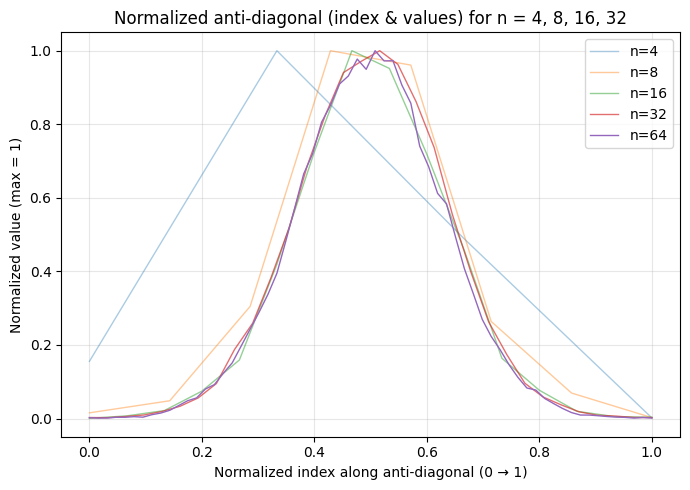

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Ns = [4, 8, 16, 32, 64]

plt.figure(figsize=(7, 5))

# tqdm for progress bar
for n in Ns:
    A = generate_signature_vector_diffusion_sym(
        n=n, sigma=n/2., source=(n//2, n//2),
        num_walks=(n//2) ** 4, p_term=0.01, gamma=1.0, seed=346511053
    ).reshape(n, n)

    anti = np.diag(np.fliplr(A))            # anti-diagonal (top-right -> bottom-left)
    y = anti / anti.max() if anti.max() else anti  # normalize values to [0,1]
    x = np.linspace(0.0, 1.0, n)            # normalize index to [0,1]

    plt.plot(x, y, lw=1, label=f"n={n}", alpha=(n+max(Ns)/2)/(1.5*max(Ns)))

plt.xlabel('Normalized index along anti-diagonal (0 → 1)')
plt.ylabel('Normalized value (max = 1)')
plt.title('Normalized anti-diagonal (index & values) for n = 4, 8, 16, 32')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Generating signature vector: 100%|██████████| 10000/10000 [00:01<00:00, 6931.84it/s]


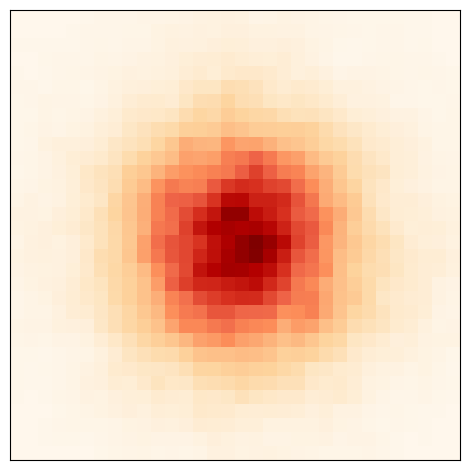

In [51]:
import matplotlib.colors as mcolors
# Original colormap
cmap = plt.get_cmap('OrRd')
cmap.set_under('white')

plt.set_cmap(cmap)
n = 32
# plt.imshow(generate_signature_vector_diffusion_sym(n=n, sigma=n / 4., source=(n // 4, n * 3 // 4 - 1), num_walks=100000, p_term=0.1, gamma=1.0, seed=346511053).reshape(n,n), cmap=cmap, vmin=0.1)
plt.imshow(generate_signature_vector_diffusion_sym(n=n, sigma=n / 2., source=(n // 2, n // 2), num_walks=10000, p_term=0.01, gamma=1.0, seed=346511053).reshape(n,n), cmap=cmap)
# show actual gaussian
# plt.imshow(rbf_kernel_torus(n, length=(n/2./2.0))[n*(n//4)+n*3//4].reshape(n, n), cmap=cmap)

# add x ticks and y ticks at integer locations
# plt.xticks(np.arange(0, n, 1))
# plt.yticks(np.arange(0, n, 1))
# remove labels
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
# remove ticks
plt.gca().tick_params(length=0)
# add very light grid lines at very fine linewidth
# plt.grid(color='white', linestyle='-', alpha=0.25)
plt.tight_layout()
# plt.savefig(f"signature_vector{n}.png", bbox_inches="tight", dpi=300)
# remove border
# plt.gca().spines[:].set_visible(False)

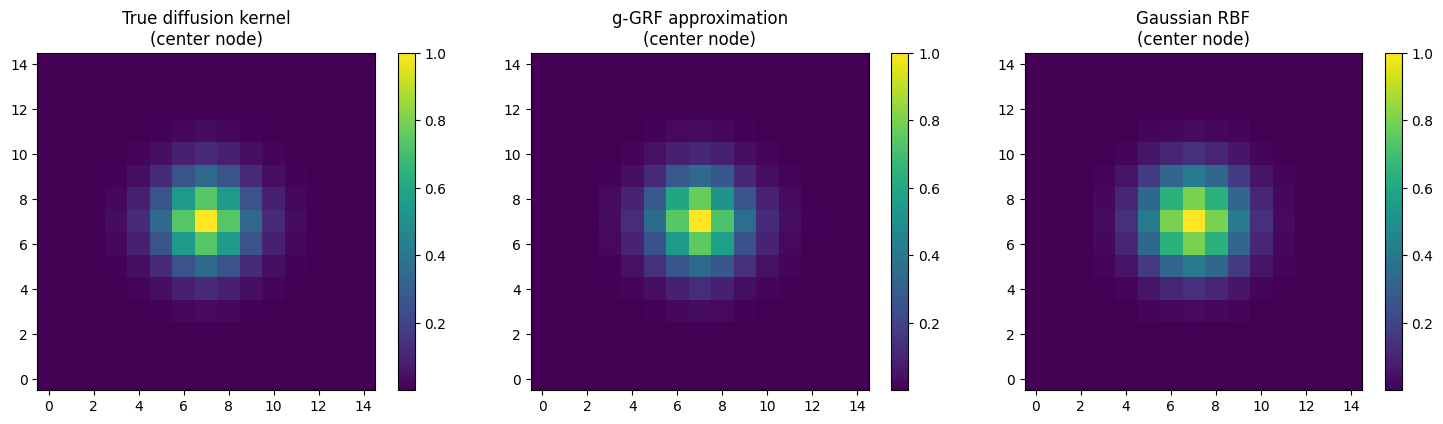

In [11]:
k_true, k_hat, k_rbf, K_true, K_hat, K_rbf = center_node_kernel(n=15, sigma=3., num_walks=1000, p_term=0.1, seed=346511053, gamma=1.)

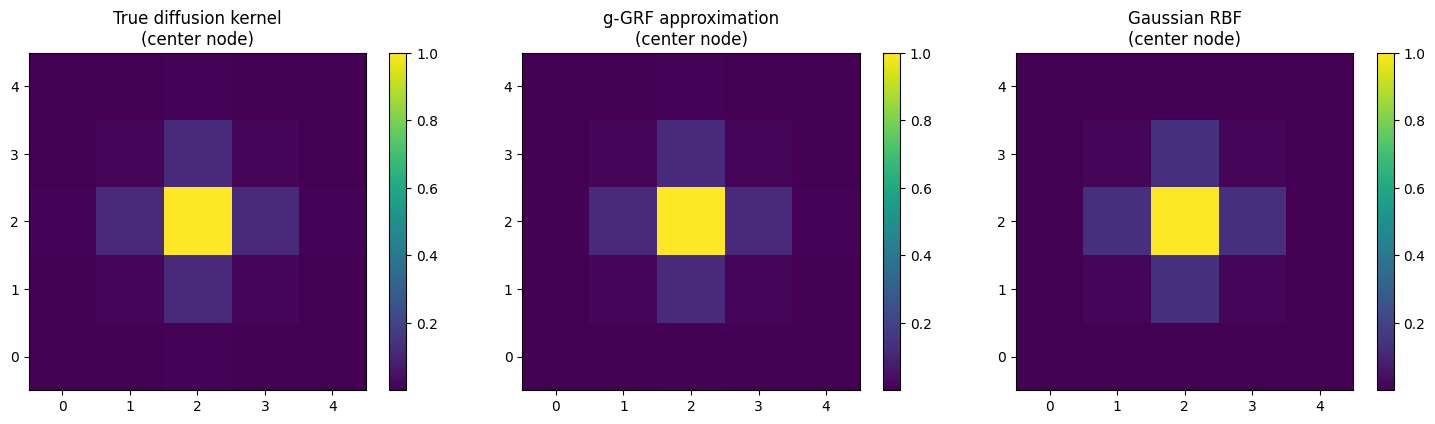

In [14]:
k_true, k_hat, k_rbf, K_true, K_hat, K_rbf = center_node_kernel(n=5, sigma=1., num_walks=1000, p_term=0.1, seed=346511053, gamma=1.)

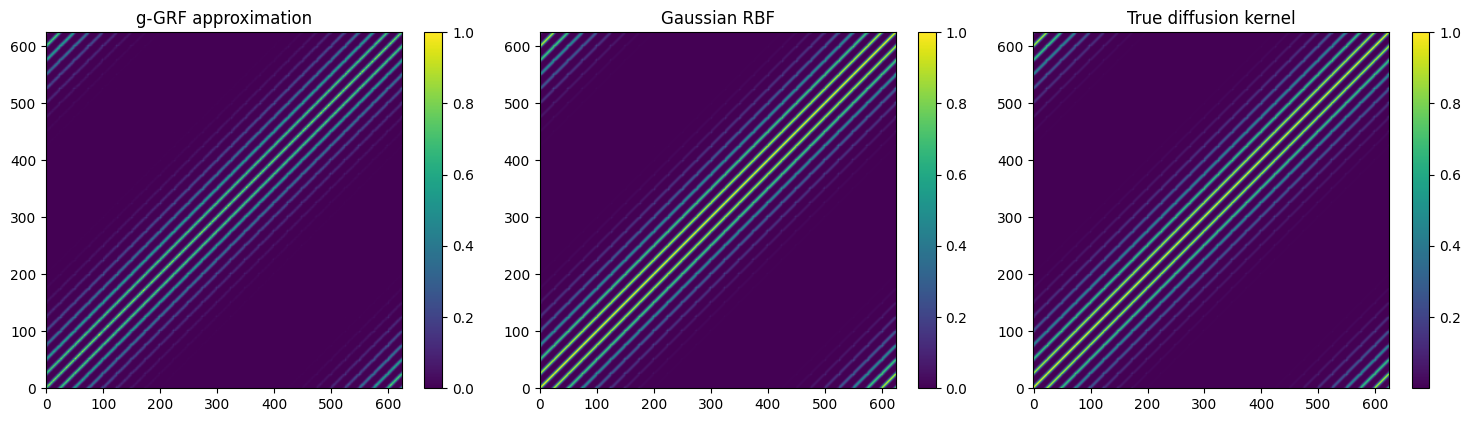

In [9]:
# plot K_hat, K_rbf, K_true
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(K_hat / (K_hat.max()), origin="lower")
plt.title("g-GRF approximation")
plt.colorbar()
plt.subplot(1, 3, 2)               
plt.imshow(K_rbf, origin="lower")
plt.title("Gaussian RBF")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(K_true / (K_true.max()), origin="lower")
plt.title("True diffusion kernel")
plt.colorbar()
plt.tight_layout()

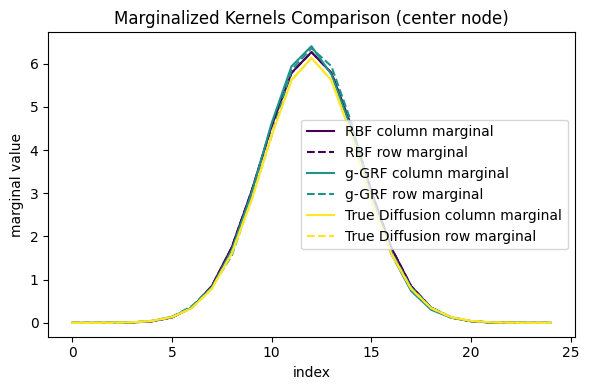

In [48]:
# plot_marginalized(k_rbf, title="Marginalized RBF Kernel (center node)")#, savepath="rbf_marginals.png")
# plot_marginalized(k_hat, title="Marginalized g-GRF Kernel (center node)")#, savepath="grf_marginals.png")
# plot_marginalized(k_true, title="Marginalized True Diffusion Kernel (center node)")#, savepath="true_diffusion_marginals.png")
plot_all_marginalized([k_rbf, k_hat, k_true], ["RBF", "g-GRF", "True Diffusion"], title="Marginalized Kernels Comparison (center node)")#, savepath="all_marginals.png")

In [ ]:
n = 25
num_walks = 1000
p_term = 0.01
gamma = 0.95

signature_vectors = [[[] for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(n):
        signature_vectors[i][j] = generate_signature_vector(n=n, source=(i, j), num_walks=num_walks, p_term=p_term, gamma=gamma)

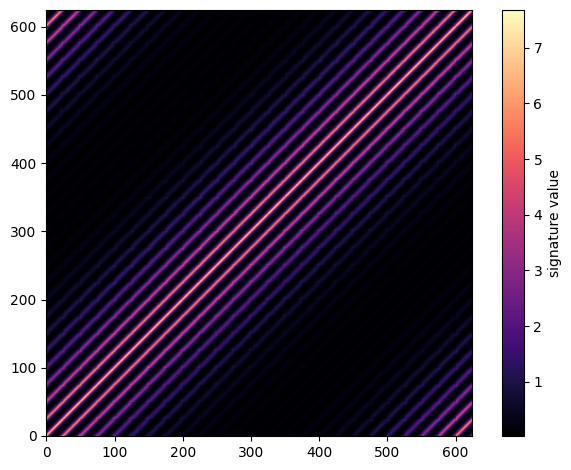

In [31]:
kernel_matrix = np.zeros((n*n, n*n), dtype=np.float64)
for i in range(n):
    for i_ in range(n):
        for j in range(n):
            for j_ in range(n):
                kernel_matrix[i*n + i_, j*n + j_] = np.multiply(signature_vectors[j][j_], signature_vectors[i][i_]).sum()
plt.set_cmap("magma")
plt.imshow(kernel_matrix, origin="lower")
plt.colorbar(label="signature value")
plt.tight_layout()

In [ ]:
num_walks = 1000
p_term = 0.01
gamma = 0.95
ns = (6,8,10,12,14,16)
mses = {n: [] for n in ns}
Ns = []
reps = 10

for n in ns:
    for _rep in range(reps):    
        signature_vectors = [[[] for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                signature_vectors[i][j] = generate_signature_vector(n=n, source=(i, j), num_walks=num_walks, p_term=p_term, gamma=gamma)

        kernel_matrix = np.zeros((n*n, n*n), dtype=np.float64)
        for i in range(n):
            for i_ in range(n):
                for j in range(n):
                    for j_ in range(n):
                        kernel_matrix[i*n + i_, j*n + j_] = np.multiply(signature_vectors[j][j_], signature_vectors[i][i_]).sum()
                        
        mses[n].append(mse(kernel_matrix, rbf_kernel_grid(n, length=4.)))
    Ns.append(n*n)

plt.figure(figsize=(6,4))
plt.plot(Ns, mses, marker="s", label="RBF vs Kernel without modulation")
plt.xlabel("number of nodes N"); plt.ylabel("MSE")
plt.title("Diffusion kernel approximation vs raw Gaussian"); plt.legend(); plt.tight_layout()

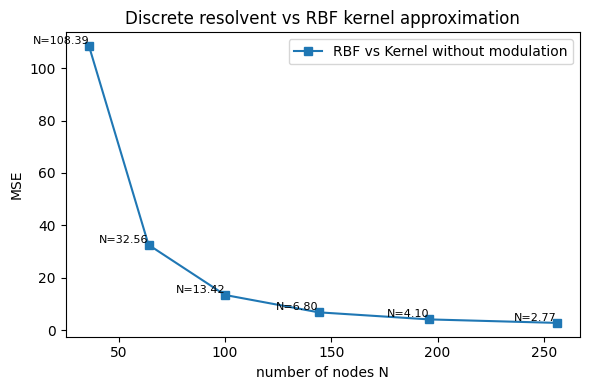

In [41]:
# included with text
plt.figure(figsize=(6,4))
plt.plot(Ns, mses, marker="s", label="RBF vs Kernel without modulation")
plt.xlabel("number of nodes N"); plt.ylabel("MSE")
plt.title("Discrete resolvent vs RBF kernel approximation")
# include text at each point
plt.text(Ns[0], mses[0], f"N={mses[0]:.2f}", fontsize=8, ha='right', va='bottom')
plt.text(Ns[1], mses[1], f"N={mses[1]:.2f}", fontsize=8, ha='right', va='bottom')
plt.text(Ns[2], mses[2], f"N={mses[2]:.2f}", fontsize=8, ha='right', va='bottom')
plt.text(Ns[3], mses[3], f"N={mses[3]:.2f}", fontsize=8, ha='right', va='bottom')
plt.text(Ns[4], mses[4], f"N={mses[4]:.2f}", fontsize=8, ha='right', va='bottom')
plt.text(Ns[5], mses[5], f"N={mses[5]:.2f}", fontsize=8, ha='right', va='bottom')
plt.legend(); plt.tight_layout()

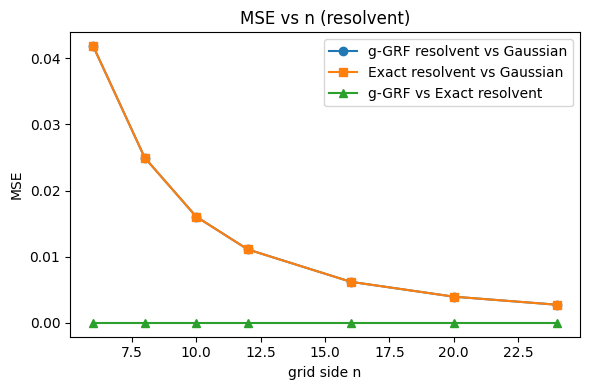

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def torus_normalized_adjacency(n):
    I = np.eye(n)
    S = np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0)     # 1D ring
    A = np.kron(S, I) + np.kron(I, S)                      # 2D grid (torus)
    return A / 4.0                                         # degree-normalized

def rbf_kernel_grid(n, length=1.0):
    X = np.stack(np.meshgrid(np.arange(n), np.arange(n), indexing="ij"), axis=-1).reshape(-1,2)
    D2 = ((X[:,None,:] - X[None,:,:])**2).sum(axis=-1)
    return np.exp(-D2/(2.0*length*length))

def resolvent_kernel_grf(n, gamma=0.9, max_terms=512, tol=1e-12):
    W = torus_normalized_adjacency(n)
    N = n*n
    Phi = np.eye(N)
    P = np.eye(N)
    fk = 1.0
    for k in range(1, max_terms+1):
        P = P @ W
        fk *= (gamma/2.0) * (2*k-1)/k
        if abs(fk) < tol: break
        Phi += fk * P
    return Phi @ Phi.T

def resolvent_kernel_exact(n, gamma=0.9):                  # optional exact check
    W = torus_normalized_adjacency(n)
    N = n*n
    I = np.eye(N)
    return np.linalg.solve(I - gamma*W, I)

def mse(A, B): return np.mean((A - B)**2)

def mse_vs_n_resolvent(ns, gamma=0.9, rbf_length=1.0, max_terms=512, tol=1e-12, compare_exact=False):
    mses_grf_vs_rbf, mses_exact_vs_rbf, mses_grf_vs_exact = [], [], []
    for n in ns:
        K_grf = resolvent_kernel_grf(n, gamma=gamma, max_terms=max_terms, tol=tol)
        K_rbf = rbf_kernel_grid(n, length=rbf_length)
        mses_grf_vs_rbf.append(mse(K_grf, K_rbf))
        if compare_exact:
            K_exact = resolvent_kernel_exact(n, gamma=gamma)
            mses_exact_vs_rbf.append(mse(K_exact, K_rbf))
            mses_grf_vs_exact.append(mse(K_grf, K_exact))
    plt.figure(figsize=(6,4))
    plt.plot(ns, mses_grf_vs_rbf, marker="o", label="g-GRF resolvent vs Gaussian")
    if compare_exact:
        plt.plot(ns, mses_exact_vs_rbf, marker="s", label="Exact resolvent vs Gaussian")
        plt.plot(ns, mses_grf_vs_exact, marker="^", label="g-GRF vs Exact resolvent")
    plt.xlabel("grid side n"); plt.ylabel("MSE"); plt.title("MSE vs n (resolvent)")
    plt.legend(); plt.tight_layout()
    return mses_grf_vs_rbf, mses_exact_vs_rbf, mses_grf_vs_exact

# Example: sweep n and plot MSE
ns = [6, 8, 10, 12, 16, 20, 24]
_ = mse_vs_n_resolvent(ns, gamma=0.9, rbf_length=1.5, max_terms=400, tol=1e-13, compare_exact=True)

## Parallelized Signature Vector Diffusion Kernel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def neighbors(r, c, n):
    return [((r-1) % n, c % n), ((r+1) % n, c % n), (r % n, (c-1) % n), (r % n, (c+1) % n)]

def generate_signature_vector_diffusion_sym(n=10, source=(0,0), num_walks=400, p_term=0.2, gamma=1.0, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    v = np.zeros((n,n), dtype=np.float64)
    rr, cc = source
    s = (sigma*sigma)/2.0
    for _ in range(num_walks):
        r, c = rr, cc
        load = 1.0
        k = 0
        fk = 1.0
        while True:
            v[r,c] += load*fk
            k += 1
            nbrs = neighbors(r,c,n); dv = 4
            wr, wc = nbrs[rng.integers(dv)]; dw = 4
            p = 1.0/dv
            u = gamma/np.sqrt(dv*dw)
            load *= u/(p*(1.0-p_term))
            r, c = wr, wc
            fk *= s/k
            if rng.random() < p_term: break
    return (v/num_walks).reshape(-1)

def exact_diffusion_kernel(n, sigma=1.0, gamma=1.0):
    N = n*n
    U = np.zeros((N,N), dtype=np.float64)
    for r in range(n):
        for c in range(n):
            i = r*n + c
            for nr, nc in neighbors(r,c,n):
                j = nr*n + nc
                U[i,j] = gamma/2.0
    L = np.eye(N) - U
    w, Q = np.linalg.eigh(L)
    return Q @ np.diag(np.exp(-0.5*(sigma**2)*w)) @ Q.T

def kernel_from_signatures(n, num_walks=400, p_term=0.2, sigma=1.0, gamma=1.0, seed=0):
    N = n*n
    Phi = np.zeros((N,N), dtype=np.float64)
    s = 0
    for r in range(n):
        for c in range(n):
            Phi[s,:] = generate_signature_vector_diffusion_sym(n, (r,c), num_walks, p_term, gamma, sigma, seed+s)
            s += 1
    return np.exp(-0.5*sigma*sigma) * (Phi @ Phi.T)

def rbf_kernel_grid(n, length=1.0):
    X = np.array([(r,c) for r in range(n) for c in range(n)], dtype=np.float64)
    D2 = np.sum((X[:,None,:]-X[None,:,:])**2, axis=2)
    return np.exp(-D2/(2.0*length*length))

def mse(A,B): return np.mean((A-B)**2)

# -----------------------------------
# helpers for parallelizing replications
# -----------------------------------

# per-process globals set once via initializer (avoid re-pickling per task)
_K_TRUE = None
_K_RBF = None
from itertools import repeat

def _khat_for_rep(n, num_walks, p_term, sigma, gamma, seed):
    # top-level so it's picklable by spawn
    return kernel_from_signatures(n, num_walks, p_term, sigma, gamma, seed)

def _init_pool(K_true, K_rbf):
    """Initializer to cache constant matrices in each worker."""
    global _K_TRUE, _K_RBF
    _K_TRUE = K_true
    _K_RBF = K_rbf

def _one_rep(seed_i, n, num_walks, p_term, sigma, gamma):
    """Compute a single replication's MSEs using cached exact/RBF kernels."""
    K_hat = kernel_from_signatures(n, num_walks, p_term, sigma, gamma, seed=seed_i)
    # Use cached per-process kernels (fall back if not set)
    K_true = _K_TRUE if (_K_TRUE is not None and _K_TRUE.shape[0] == n*n) else exact_diffusion_kernel(n, sigma, gamma)
    K_rbf = _K_RBF  if (_K_RBF  is not None and _K_RBF.shape[0]  == n*n) else rbf_kernel_grid(n, length=sigma)
    return mse(K_hat, K_true), mse(K_hat, K_rbf)

# ----------------------------
# parallelized run_curve
# ----------------------------
import os
from concurrent.futures import ProcessPoolExecutor

def run_curve_parallel(ns=(10,12,14,16),
                       num_walks=300, p_term=0.01,
                       sigma=4.0, gamma=.95,
                       seed=0, reps=100,
                       max_workers=None):
    """
    Parallelizes over 'reps' for each n.
    Computes K_true and K_rbf once per n in the parent.
    """
    max_workers = max_workers or (os.cpu_count() or 1)

    # lists of length `reps`, each holding a list over |ns|
    mses_rf  = [[] for _ in range(reps)]
    mses_rbf = [[] for _ in range(reps)]
    mses_true_vs_exact_kernel = [[] for _ in range(reps)]
    Ns = []

    for n in ns:
        print(n)
        # Precompute once per n (deterministic)
        K_true = exact_diffusion_kernel(n, sigma, gamma)
        K_rbf  = rbf_kernel_grid(n, length=sigma)

        seeds = [seed + i for i in range(reps)]

        # Dispatch replications in parallel; map preserves order
        # so i-th result corresponds to seed+i
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            # chunksize=1 is fine for moderate reps; tune if reps is very large
            for i, K_hat in enumerate(
                ex.map(_khat_for_rep,
                       repeat(n),
                       repeat(num_walks),
                       repeat(p_term),
                       repeat(sigma),
                       repeat(gamma),
                       seeds,
                       chunksize=1)
            ):
                mses_rf[i].append(mse(K_hat, K_true))
                mses_rbf[i].append(mse(K_hat, K_rbf))
                # this one doesn't depend on the replication; append once
                if len(mses_true_vs_exact_kernel[i]) < len(Ns) + 1:
                    mses_true_vs_exact_kernel[i].append(mse(K_true, K_rbf))

        Ns.append(n*n)

    return Ns, mses_rf, mses_rbf, mses_true_vs_exact_kernel

# Example usage:
Ns, mses_rf, mses_rbf, mses_true_vs_exact_kernel = run_curve_parallel(max_workers=8)

## Training

In [ ]:
# ============================================================
# End-to-end: Learn f(x, ω) ≈ φ_t(x)[ω] on S^2
#  - Build sphere graph + g-GRF signatures (diffusion modulation α_k = t^k/k!)
#  - Dataset: ([x_j || ω_{j,i}], target = φ_t(x_j)[ω_{j,i}])
#  - Train NN: continuous features (coords + geodesic). Optionally add ID embeddings.
# ============================================================

import math
import numpy as np
from typing import Dict, List, Tuple, Any

# =============== CONFIG ===============
CFG = dict(
    N=600,                # sphere sample size
    k=8,                 # kNN
    num_starts=200,       # number of x_j
    start_mode="farthest",# or "random"
    n_walks=2000,         # by default = N (per start)
    phalt=0.01,           # termination prob in Alg. 1
    t=10.,                # diffusion scale (τ = t)
    seed=7,

    subsample_per_start=None,  # None = use all ω; or int (e.g., 300)

    # model/training
    use_continuous_only=True,  # True: only coords+geodesic (continuous RF); False: + ID embeddings
    d_emb=64,
    hidden=128,
    batch_size=1024,
    lr=1e-3,
    epochs=100,
    val_frac=0.2,
    torch_seed=0,
)
# ======================================

# ----------------------------
# Sphere + graph + g-GRF (Alg. 1) signatures
# ----------------------------

def fibonacci_sphere(n: int) -> np.ndarray:
    i = np.arange(n, dtype=float)
    phi = np.pi * (3.0 - np.sqrt(5.0))
    y = 1.0 - 2.0 * (i + 0.5) / n
    r = np.sqrt(np.maximum(0.0, 1.0 - y * y))
    theta = phi * (i + 0.5)
    x = np.cos(theta) * r
    z = np.sin(theta) * r
    return np.column_stack((x, y, z))

def build_knn_graph(X: np.ndarray, k: int = 16):
    """Symmetric kNN with Gaussian weights; return W_raw, Wf, neighbors, deg_unw, sigma^2."""
    N = X.shape[0]
    XXT = X @ X.T
    D2 = np.clip(2.0 - 2.0 * XXT, 0.0, None)  # chord^2 on S^2
    np.fill_diagonal(D2, np.inf)
    kth_sq = np.partition(D2, k, axis=1)[:, k]
    sigma2 = float(np.median(kth_sq))
    W = np.zeros((N, N), dtype=float)
    for i in range(N):
        nn = np.argpartition(D2[i], k)[:k]
        W[i, nn] = np.exp(-D2[i, nn] / sigma2)
    W = np.maximum(W, W.T)
    np.fill_diagonal(W, 0.0)
    deg = W.sum(axis=1)
    D_inv_sqrt = 1.0 / np.sqrt(deg + 1e-12)
    Wf = (D_inv_sqrt[:, None] * W) * D_inv_sqrt[None, :]
    A_unw = (W > 0).astype(np.int32)
    deg_unw = A_unw.sum(axis=1).astype(np.int32)
    neighbors = [np.flatnonzero(A_unw[i]).astype(np.int32) for i in range(N)]
    return W, Wf, neighbors, deg_unw, sigma2

def farthest_point_sample(coords: np.ndarray, m: int, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    N = coords.shape[0]
    start = int(rng.integers(0, N))
    sel = [start]
    d2 = np.sum((coords - coords[start])**2, axis=1)
    for _ in range(1, m):
        idx = int(np.argmax(d2))
        sel.append(idx)
        d2 = np.minimum(d2, np.sum((coords - coords[idx])**2, axis=1))
    return np.array(sel, dtype=int)

def precompute_alpha(tau: float, Kmax: int = 10000, eps: float = 1e-300) -> np.ndarray:
    """Diffusion modulation α_k = τ^k / k! via stable recurrence; α_0=1."""
    vals = [1.0]
    k = 1
    while k < Kmax:
        nxt = vals[-1] * (tau / k)
        if nxt < eps: break
        vals.append(nxt); k += 1
    return np.array(vals, dtype=float)

def build_ggrf_signatures_on_sphere(
    N: int, k: int, num_starts: int, start_mode: str,
    n_walks: int | None, phalt: float, tau: float, seed: int
) -> Dict[str, Any]:
    """
    Build signatures φ_t(x_j) using g-GRF Algorithm 1 with uniform-by-count neighbor sampling.
    Returns dict with:
      X (N,3), start_indices (J,), starts_xyz (J,3),
      phi (J, N), params {...}
    """
    rng = np.random.default_rng(seed)
    X = fibonacci_sphere(N)
    W_raw, Wf, neighbors, deg_unw, sigma2 = build_knn_graph(X, k=k)

    if start_mode == "farthest":
        start_indices = farthest_point_sample(X, num_starts, seed=seed)
    elif start_mode == "random":
        start_indices = rng.choice(N, size=num_starts, replace=False)
    else:
        raise ValueError("start_mode must be 'farthest' or 'random'")

    alpha = precompute_alpha(tau, Kmax=10000, eps=1e-300)
    def modulation(step: int) -> float:
        return float(alpha[step]) if step < alpha.shape[0] else 0.0

    if n_walks is None: n_walks = N

    phi = np.zeros((num_starts, N), dtype=float)

    def sample_feature(start_idx: int):
        vec = np.zeros(N, dtype=float)
        local_rng = np.random.default_rng(int(seed) * 1009 + int(start_idx))
        while vec.dtype == float:  # silly loop to scope variables (runs once)
            for _ in range(n_walks):
                u = int(start_idx)
                load = 1.0
                step = 0
                terminated = False
                while not terminated:
                    vec[u] += load * modulation(step)
                    step += 1
                    nbrs = neighbors[u]
                    if nbrs.size == 0: break
                    v = int(nbrs[local_rng.integers(0, nbrs.size)])
                    # Alg. 1 update (uniform-by-count neighbor sampling):
                    load *= (deg_unw[u] / (1.0 - phalt)) * float(Wf[u, v])
                    u = v
                    terminated = (local_rng.random() < phalt)
            break
        vec /= float(n_walks)
        return vec

    for j, s in enumerate(start_indices):
        phi[j] = sample_feature(int(s))

    return {
        "X": X,
        "start_indices": start_indices,
        "starts_xyz": X[start_indices],
        "phi": phi,
        "params": {
            "N": int(N), "k": int(k), "num_starts": int(num_starts),
            "start_mode": start_mode, "n_walks": int(n_walks),
            "phalt": float(phalt), "tau": float(tau), "sigma2": float(sigma2)
        }
    }

# ----------------------------
# Supervision: (x_j, ω_{j,i}) -> y_{j,i} = φ_t(x_j)[ω_{j,i}]
# ----------------------------

def make_node_pair_supervision(out: Dict[str, Any],
                               mode: str = "all", M_per_start: int | None = None,
                               seed: int = 123):
    """
    Build arrays: start_ids (M,), omega_ids (M,), targets (M,) and geometry arrays.
    If M_per_start is set with mode="random", uniformly subsample that many ω per start x_j.
    """
    X = out["X"]
    start_ids = out["start_indices"]
    phi = out["phi"]
    N = X.shape[0]
    rng = np.random.default_rng(seed)

    starts, omegas, targets = [], [], []
    for j, s in enumerate(start_ids):
        nodes = np.arange(N)
        if mode == "random" and (M_per_start is not None) and (M_per_start < N):
            nodes = rng.choice(N, size=M_per_start, replace=False)
        for i in nodes:
            starts.append(int(s))
            omegas.append(int(i))
            targets.append(float(phi[j, i]))

    starts = np.array(starts, dtype=np.int64)
    omegas = np.array(omegas, dtype=np.int64)
    targets = np.array(targets, dtype=np.float32)
    return {"starts": starts, "omegas": omegas, "targets": targets, "X": X, "N": N}

# ----------------------------
# PyTorch model (continuous RF by default)
# ----------------------------

def ensure_torch():
    try:
        import torch  # noqa: F401
        return True
    except Exception:
        print("PyTorch not found. Please install torch.")
        return False

if ensure_torch():
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader

    class NodePairDataset(Dataset):
        def __init__(self, sup: Dict[str, Any], use_continuous_only: bool = True):
            self.starts = sup["starts"]      # (M,)
            self.omegas = sup["omegas"]      # (M,)
            self.targets = sup["targets"]    # (M,)
            self.X = sup["X"]                # (N,3)
            self.use_cont = use_continuous_only
        def __len__(self): return len(self.targets)
        def __getitem__(self, idx):
            s = int(self.starts[idx]); o = int(self.omegas[idx])
            start_xyz = self.X[s].astype(np.float32)
            omega_xyz = self.X[o].astype(np.float32)
            dot = float(np.clip(np.dot(start_xyz, omega_xyz), -1.0, 1.0))
            geod = float(np.arccos(dot))
            ex = {
                "start": s, "omega": o,
                "start_xyz": start_xyz, "omega_xyz": omega_xyz,
                "geod": geod, "target": float(self.targets[idx])
            }
            return ex

    def collate(batch):
        import torch
        return {
            "start": torch.tensor([b["start"] for b in batch], dtype=torch.long),
            "omega": torch.tensor([b["omega"] for b in batch], dtype=torch.long),
            "start_xyz": torch.tensor([b["start_xyz"] for b in batch], dtype=torch.float32),
            "omega_xyz": torch.tensor([b["omega_xyz"] for b in batch], dtype=torch.float32),
            "geod": torch.tensor([b["geod"] for b in batch], dtype=torch.float32).unsqueeze(-1),
            "target": torch.tensor([b["target"] for b in batch], dtype=torch.float32),
        }

    class SignatureAtNodeRegressor(nn.Module):
        """
        f(x, ω): default uses ONLY coords + geodesic (continuous RF).
        If use_ids=True, adds ID embeddings for start and omega.
        """
        def __init__(self, num_nodes: int, x_coords: np.ndarray,
                     d_emb: int = 64, hidden: int = 128,
                     use_continuous_only: bool = True):
            super().__init__()
            self.register_buffer("Xcoords", torch.tensor(x_coords, dtype=torch.float32))  # (N,3)
            self.use_cont = use_continuous_only
            self.use_ids = not use_continuous_only
            if self.use_ids:
                self.start_emb = nn.Embedding(num_nodes, d_emb)
                self.omega_emb = nn.Embedding(num_nodes, d_emb)

            # inputs: geod (1), start_xyz (3), omega_xyz (3) -> 7 dims
            in_dim = 7
            if self.use_ids:
                in_dim += 2 * d_emb

            self.mlp = nn.Sequential(
                nn.Linear(in_dim, hidden), nn.ReLU(),
                nn.Linear(hidden, hidden // 2), nn.ReLU(),
                nn.Linear(hidden // 2, hidden // 4), nn.ReLU(),
                nn.Linear(hidden // 4, hidden // 8), nn.ReLU(),
                nn.Linear(hidden // 8, 1)
            )

        def forward(self, batch):
            s = batch["start"]; o = batch["omega"]; geod = batch["geod"]
            pieces = [batch["start_xyz"], batch["omega_xyz"], geod]
            if self.use_ids:
                s_emb = self.start_emb(s); o_emb = self.omega_emb(o)
                pieces = [s_emb, o_emb] + pieces
            x = torch.cat(pieces, dim=-1)
            return self.mlp(x).squeeze(-1)

    # ----------------------------
    # Training utilities
    # ----------------------------

    def split_indices(M, val_frac=0.2, seed=0):
        rng = np.random.default_rng(seed)
        idx = np.arange(M); rng.shuffle(idx)
        k = int(M * (1 - val_frac))
        return idx[:k], idx[k:]

    def train_model_node_pairs(
        sup: Dict[str, Any],
        batch_size=1024, epochs=8, lr=1e-3,
        d_emb=64, hidden=128, use_continuous_only=True, val_frac=0.2, seed=0
    ):
        import torch
        ds = NodePairDataset(sup, use_continuous_only=use_continuous_only)
        train_idx, val_idx = split_indices(len(ds), val_frac=val_frac, seed=seed)

        class Subset(torch.utils.data.Dataset):
            def __init__(self, base, idxs): self.base, self.idxs = base, idxs
            def __len__(self): return len(self.idxs)
            def __getitem__(self, i): return self.base[self.idxs[i]]

        tr_ds, va_ds = Subset(ds, train_idx), Subset(ds, val_idx)
        tr = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, collate_fn=collate, drop_last=False)
        va = DataLoader(va_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=False)

        model = SignatureAtNodeRegressor(
            num_nodes=sup["N"], x_coords=sup["X"],
            d_emb=d_emb, hidden=hidden, use_continuous_only=use_continuous_only
        )
        torch.manual_seed(seed)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()

        def eval_loader(dl):
            model.eval()
            se, n = 0.0, 0
            with torch.no_grad():
                for batch in dl:
                    pred = model(batch); y = batch["target"]
                    se += torch.sum((pred - y)**2).item()
                    n += y.numel()
            return math.sqrt(se / n)

        for ep in range(1, epochs+1):
            model.train()
            for batch in tr:
                pred = model(batch); y = batch["target"]
                loss = loss_fn(pred, y)
                opt.zero_grad(); loss.backward(); opt.step()
            rmse_tr = eval_loader(tr)
            rmse_va = eval_loader(va)
            print(f"Epoch {ep:02d} | RMSE train: {rmse_tr:.6f} | RMSE val: {rmse_va:.6f}")
        return model

# ----------------------------
# Main: build data → train NN
# ----------------------------

def main(CFG):
    N, k = CFG["N"], CFG["k"]
    num_starts, start_mode = CFG["num_starts"], CFG["start_mode"]
    n_walks, phalt, t, seed = CFG["n_walks"], CFG["phalt"], CFG["t"], CFG["seed"]

    out = build_ggrf_signatures_on_sphere(
        N=N, k=k, num_starts=num_starts, start_mode=start_mode,
        n_walks=n_walks, phalt=phalt, tau=t, seed=seed
    )
    print("Built signatures:", {k: out["params"][k] for k in ["N","k","num_starts","n_walks","phalt","tau"]})

    sup = make_node_pair_supervision(
        out,
        mode=("all" if CFG["subsample_per_start"] is None else "random"),
        M_per_start=CFG["subsample_per_start"],
        seed=123
    )
    sup["N"] = out["params"]["N"]  # add for model ctor
    print("Dataset size:", len(sup["targets"]))

    if ensure_torch():
        model = train_model_node_pairs(
            sup,
            batch_size=CFG["batch_size"],
            epochs=CFG["epochs"],
            lr=CFG["lr"],
            d_emb=CFG["d_emb"],
            hidden=CFG["hidden"],
            use_continuous_only=CFG["use_continuous_only"],
            val_frac=CFG["val_frac"],
            seed=CFG["torch_seed"]
        )
    
    return out, model

if __name__ == "__main__":
    out, model = main(CFG)


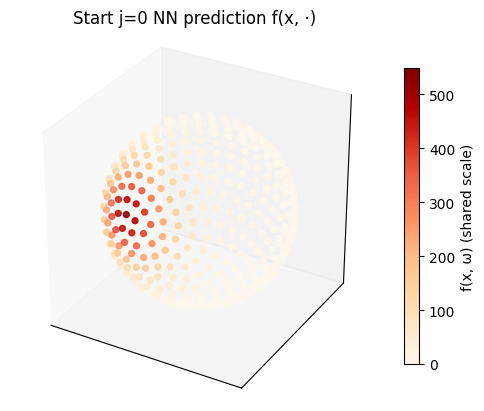

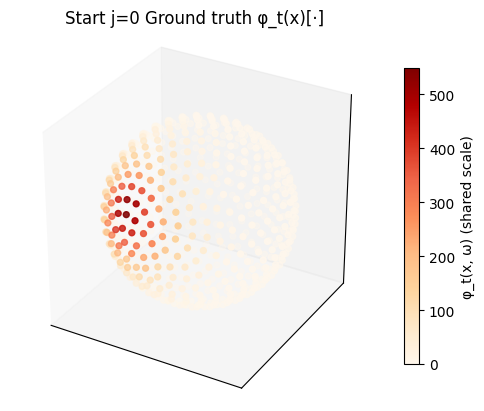

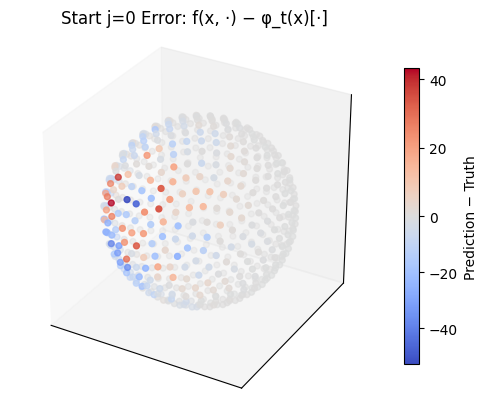

In [11]:
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.cm import ScalarMappable

def plot_fx_field(model, X, start_indices, phi, j_star=0, title_prefix="",
                  share_norm=True,  # use same vmin/vmax for pred & truth
                  cmap_main="OrRd", cmap_err="coolwarm"):
    """
    Visualize f(x, ·), φ_t(x)[·], and error with colorbars.

    share_norm=True -> pred & truth use the SAME (vmin, vmax) from unnormalized values.
    If you want heat-kernel scale instead of φ_t, divide both arrays by exp(t) before plotting.
    """
    model.eval()
    device = next(model.parameters()).device
    N = X.shape[0]
    s = int(start_indices[j_star])
    start_xyz = X[s]
    omega_xyz = X
    dots = np.clip((omega_xyz * start_xyz).sum(axis=1), -1.0, 1.0)
    geod = np.arccos(dots)

    # batch with IDs + continuous feats (works for both model variants)
    batch = {
        "start": torch.full((N,), s, dtype=torch.long, device=device),
        "omega": torch.arange(N, dtype=torch.long, device=device),
        "start_xyz": torch.tensor(np.repeat(start_xyz[None,:], N, axis=0), dtype=torch.float32, device=device),
        "omega_xyz": torch.tensor(omega_xyz, dtype=torch.float32, device=device),
        "geod": torch.tensor(geod[:,None], dtype=torch.float32, device=device),
    }
    with torch.no_grad():
        f_pred = model(batch).detach().cpu().numpy()

    # ground truth row for this start
    j = int(np.where(start_indices == s)[0][0])
    phi_row = phi[j].astype(float)

    # ---- normalization choices ----
    if share_norm:
        vmin = min(f_pred.min(), phi_row.min())
        vmax = max(f_pred.max(), phi_row.max())
        norm_main = Normalize(vmin=vmin, vmax=vmax)
        f_vis = f_pred
        g_vis = phi_row
    else:
        # independent [0,1] normalization for each
        def norm01(v): v = v - v.min(); return v / (v.max() + 1e-12)
        f_vis = norm01(f_pred); g_vis = norm01(phi_row)
        norm_main = Normalize(vmin=0.0, vmax=1.0)

    err = f_pred - phi_row
    norm_err = TwoSlopeNorm(vmin=err.min(), vcenter=0.0, vmax=err.max())

    # ---- PRED ----
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    sc1 = ax1.scatter(X[:,0], X[:,1], X[:,2], s=18, c=f_vis, cmap=cmap_main, norm=norm_main)
    ax1.set_title(f"{title_prefix} NN prediction f(x, ·)")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([]); ax1.set_box_aspect([1,1,1])
    cbar1 = fig1.colorbar(ScalarMappable(norm=norm_main, cmap=cmap_main), ax=ax1, shrink=0.8)
    cbar1.set_label("f(x, ω)" + (" (shared scale)" if share_norm else " (individually normalized)"))
    plt.show()

    # ---- TRUTH ----
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    sc2 = ax2.scatter(X[:,0], X[:,1], X[:,2], s=18, c=g_vis, cmap=cmap_main, norm=norm_main)
    ax2.set_title(f"{title_prefix} Ground truth φ_t(x)[·]")
    ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([]); ax2.set_box_aspect([1,1,1])
    cbar2 = fig2.colorbar(ScalarMappable(norm=norm_main, cmap=cmap_main), ax=ax2, shrink=0.8)
    cbar2.set_label("φ_t(x, ω)" + (" (shared scale)" if share_norm else " (individually normalized)"))
    plt.show()

    # ---- ERROR ----
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111, projection='3d')
    sc3 = ax3.scatter(X[:,0], X[:,1], X[:,2], s=18, c=err, cmap=cmap_err, norm=norm_err)
    ax3.set_title(f"{title_prefix} Error: f(x, ·) − φ_t(x)[·]")
    ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([]); ax3.set_box_aspect([1,1,1])
    cbar3 = fig3.colorbar(ScalarMappable(norm=norm_err, cmap=cmap_err), ax=ax3, shrink=0.8)
    cbar3.set_label("Prediction − Truth")
    plt.show()


X  = out["X"]
phi = out["phi"]
start_indices = out["start_indices"]

plot_fx_field(model, X, start_indices, phi, j_star=0, title_prefix="Start j=0")


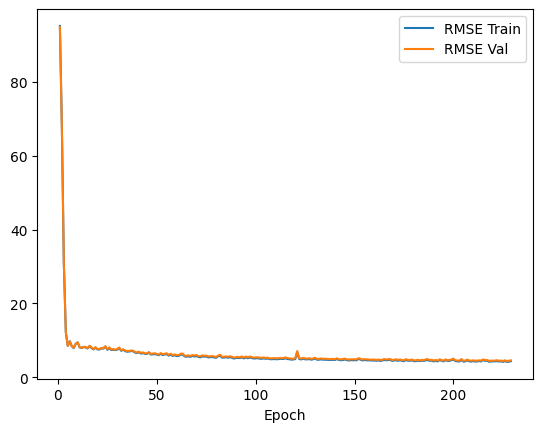

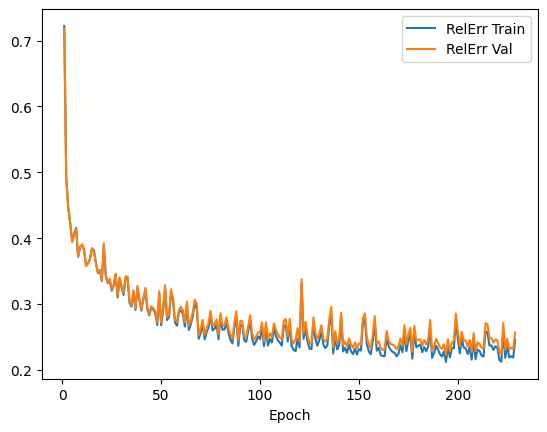

In [11]:
import matplotlib.pyplot as plt
import re

loss = """Epoch 01 | RMSE train: 95.159205 | RMSE val: 94.879650 | RelErr train: 0.722351 | RelErr val: 0.718118
Epoch 02 | RMSE train: 67.934022 | RMSE val: 67.604330 | RelErr train: 0.492637 | RelErr val: 0.490120
Epoch 03 | RMSE train: 30.974143 | RMSE val: 30.829717 | RelErr train: 0.447293 | RelErr val: 0.445473
Epoch 04 | RMSE train: 12.177518 | RMSE val: 12.184024 | RelErr train: 0.423316 | RelErr val: 0.422835
Epoch 05 | RMSE train: 8.467632 | RMSE val: 8.444270 | RelErr train: 0.394537 | RelErr val: 0.394090
Epoch 06 | RMSE train: 9.734143 | RMSE val: 9.689330 | RelErr train: 0.406418 | RelErr val: 0.404531
Epoch 07 | RMSE train: 8.385738 | RMSE val: 8.428972 | RelErr train: 0.415812 | RelErr val: 0.414224
Epoch 08 | RMSE train: 7.882524 | RMSE val: 7.971747 | RelErr train: 0.371597 | RelErr val: 0.372630
Epoch 09 | RMSE train: 9.013793 | RMSE val: 9.081968 | RelErr train: 0.386495 | RelErr val: 0.386333
Epoch 10 | RMSE train: 9.432519 | RMSE val: 9.396091 | RelErr train: 0.389396 | RelErr val: 0.390757
Epoch 11 | RMSE train: 8.058294 | RMSE val: 8.147430 | RelErr train: 0.382182 | RelErr val: 0.382630
Epoch 12 | RMSE train: 7.907740 | RMSE val: 7.941306 | RelErr train: 0.358386 | RelErr val: 0.357756
Epoch 13 | RMSE train: 8.157435 | RMSE val: 8.250824 | RelErr train: 0.361605 | RelErr val: 0.361310
Epoch 14 | RMSE train: 8.062271 | RMSE val: 8.150299 | RelErr train: 0.368098 | RelErr val: 0.368874
Epoch 15 | RMSE train: 7.774522 | RMSE val: 7.849651 | RelErr train: 0.384059 | RelErr val: 0.384682
Epoch 16 | RMSE train: 8.418351 | RMSE val: 8.505954 | RelErr train: 0.381834 | RelErr val: 0.378788
Epoch 17 | RMSE train: 7.882682 | RMSE val: 8.047866 | RelErr train: 0.362241 | RelErr val: 0.361933
Epoch 18 | RMSE train: 7.503827 | RMSE val: 7.610991 | RelErr train: 0.346888 | RelErr val: 0.348189
Epoch 19 | RMSE train: 8.023074 | RMSE val: 8.110466 | RelErr train: 0.351086 | RelErr val: 0.351626
Epoch 20 | RMSE train: 7.503614 | RMSE val: 7.626196 | RelErr train: 0.334870 | RelErr val: 0.336130
Epoch 21 | RMSE train: 7.499620 | RMSE val: 7.648864 | RelErr train: 0.390024 | RelErr val: 0.392077
Epoch 22 | RMSE train: 7.766932 | RMSE val: 7.903011 | RelErr train: 0.342457 | RelErr val: 0.343594
Epoch 23 | RMSE train: 7.749525 | RMSE val: 7.858788 | RelErr train: 0.331702 | RelErr val: 0.331946
Epoch 24 | RMSE train: 8.303405 | RMSE val: 8.389208 | RelErr train: 0.335832 | RelErr val: 0.338407
Epoch 25 | RMSE train: 7.395898 | RMSE val: 7.566996 | RelErr train: 0.319967 | RelErr val: 0.321595
Epoch 26 | RMSE train: 7.889049 | RMSE val: 8.058715 | RelErr train: 0.328211 | RelErr val: 0.328921
Epoch 27 | RMSE train: 7.347630 | RMSE val: 7.514014 | RelErr train: 0.345053 | RelErr val: 0.346169
Epoch 28 | RMSE train: 7.426839 | RMSE val: 7.624088 | RelErr train: 0.309979 | RelErr val: 0.311127
Epoch 29 | RMSE train: 7.329396 | RMSE val: 7.422210 | RelErr train: 0.338707 | RelErr val: 0.340288
Epoch 30 | RMSE train: 7.464543 | RMSE val: 7.672914 | RelErr train: 0.324989 | RelErr val: 0.326404
Epoch 31 | RMSE train: 7.881819 | RMSE val: 8.040185 | RelErr train: 0.313634 | RelErr val: 0.316866
Epoch 32 | RMSE train: 7.132437 | RMSE val: 7.296986 | RelErr train: 0.339595 | RelErr val: 0.342054
Epoch 33 | RMSE train: 7.448179 | RMSE val: 7.564542 | RelErr train: 0.339672 | RelErr val: 0.341542
Epoch 34 | RMSE train: 7.052781 | RMSE val: 7.177647 | RelErr train: 0.301810 | RelErr val: 0.304420
Epoch 35 | RMSE train: 6.890304 | RMSE val: 7.112557 | RelErr train: 0.296158 | RelErr val: 0.298423
Epoch 36 | RMSE train: 6.953870 | RMSE val: 7.106352 | RelErr train: 0.318368 | RelErr val: 0.320660
Epoch 37 | RMSE train: 7.072112 | RMSE val: 7.211840 | RelErr train: 0.290938 | RelErr val: 0.293466
Epoch 38 | RMSE train: 7.034044 | RMSE val: 7.170201 | RelErr train: 0.325298 | RelErr val: 0.327273
Epoch 39 | RMSE train: 6.661862 | RMSE val: 6.854424 | RelErr train: 0.305966 | RelErr val: 0.308541
Epoch 40 | RMSE train: 6.531438 | RMSE val: 6.691477 | RelErr train: 0.289802 | RelErr val: 0.291658
Epoch 41 | RMSE train: 6.765435 | RMSE val: 6.929126 | RelErr train: 0.307089 | RelErr val: 0.309204
Epoch 42 | RMSE train: 6.366270 | RMSE val: 6.547442 | RelErr train: 0.321078 | RelErr val: 0.324339
Epoch 43 | RMSE train: 6.524318 | RMSE val: 6.702218 | RelErr train: 0.291652 | RelErr val: 0.295653
Epoch 44 | RMSE train: 6.305685 | RMSE val: 6.470074 | RelErr train: 0.282572 | RelErr val: 0.283870
Epoch 45 | RMSE train: 6.294706 | RMSE val: 6.469668 | RelErr train: 0.294758 | RelErr val: 0.296672
Epoch 46 | RMSE train: 6.668957 | RMSE val: 6.786467 | RelErr train: 0.291731 | RelErr val: 0.293379
Epoch 47 | RMSE train: 6.124296 | RMSE val: 6.312451 | RelErr train: 0.285708 | RelErr val: 0.289562
Epoch 48 | RMSE train: 6.197069 | RMSE val: 6.411758 | RelErr train: 0.267869 | RelErr val: 0.271627
Epoch 49 | RMSE train: 6.244931 | RMSE val: 6.474190 | RelErr train: 0.315114 | RelErr val: 0.319359
Epoch 50 | RMSE train: 6.127729 | RMSE val: 6.320757 | RelErr train: 0.267630 | RelErr val: 0.271192
Epoch 51 | RMSE train: 5.950697 | RMSE val: 6.126275 | RelErr train: 0.290138 | RelErr val: 0.294071
Epoch 52 | RMSE train: 6.330131 | RMSE val: 6.522031 | RelErr train: 0.324463 | RelErr val: 0.328534
Epoch 53 | RMSE train: 5.994094 | RMSE val: 6.216677 | RelErr train: 0.275525 | RelErr val: 0.279680
Epoch 54 | RMSE train: 6.152958 | RMSE val: 6.331013 | RelErr train: 0.280262 | RelErr val: 0.284178
Epoch 55 | RMSE train: 6.257567 | RMSE val: 6.479906 | RelErr train: 0.318070 | RelErr val: 0.322412
Epoch 56 | RMSE train: 5.842569 | RMSE val: 6.046844 | RelErr train: 0.304475 | RelErr val: 0.308793
Epoch 57 | RMSE train: 6.096365 | RMSE val: 6.347075 | RelErr train: 0.271701 | RelErr val: 0.276327
Epoch 58 | RMSE train: 5.760152 | RMSE val: 5.982263 | RelErr train: 0.266992 | RelErr val: 0.272289
Epoch 59 | RMSE train: 5.923009 | RMSE val: 6.133904 | RelErr train: 0.287970 | RelErr val: 0.291189
Epoch 60 | RMSE train: 5.713674 | RMSE val: 5.977816 | RelErr train: 0.289617 | RelErr val: 0.295490
Epoch 61 | RMSE train: 5.734184 | RMSE val: 5.970146 | RelErr train: 0.284916 | RelErr val: 0.290220
Epoch 62 | RMSE train: 6.069044 | RMSE val: 6.328258 | RelErr train: 0.265727 | RelErr val: 0.272325
Epoch 63 | RMSE train: 6.166468 | RMSE val: 6.411750 | RelErr train: 0.297409 | RelErr val: 0.303643
Epoch 64 | RMSE train: 5.639414 | RMSE val: 5.873277 | RelErr train: 0.260363 | RelErr val: 0.266651
Epoch 65 | RMSE train: 5.532658 | RMSE val: 5.767418 | RelErr train: 0.269342 | RelErr val: 0.275217
Epoch 66 | RMSE train: 5.660559 | RMSE val: 5.914221 | RelErr train: 0.281675 | RelErr val: 0.287803
Epoch 67 | RMSE train: 5.480480 | RMSE val: 5.733158 | RelErr train: 0.300324 | RelErr val: 0.306389
Epoch 68 | RMSE train: 5.774911 | RMSE val: 5.989616 | RelErr train: 0.292869 | RelErr val: 0.300185
Epoch 69 | RMSE train: 5.592153 | RMSE val: 5.853087 | RelErr train: 0.247071 | RelErr val: 0.252735
Epoch 70 | RMSE train: 5.727677 | RMSE val: 6.014645 | RelErr train: 0.256508 | RelErr val: 0.262012
Epoch 71 | RMSE train: 5.486831 | RMSE val: 5.692492 | RelErr train: 0.269106 | RelErr val: 0.275982
Epoch 72 | RMSE train: 5.388510 | RMSE val: 5.666545 | RelErr train: 0.246149 | RelErr val: 0.252997
Epoch 73 | RMSE train: 5.630758 | RMSE val: 5.899138 | RelErr train: 0.257282 | RelErr val: 0.262839
Epoch 74 | RMSE train: 5.539513 | RMSE val: 5.805547 | RelErr train: 0.264938 | RelErr val: 0.271637
Epoch 75 | RMSE train: 5.619980 | RMSE val: 5.837957 | RelErr train: 0.282795 | RelErr val: 0.289510
Epoch 76 | RMSE train: 5.354005 | RMSE val: 5.645543 | RelErr train: 0.259751 | RelErr val: 0.266558
Epoch 77 | RMSE train: 5.427285 | RMSE val: 5.654965 | RelErr train: 0.262273 | RelErr val: 0.269510
Epoch 78 | RMSE train: 5.457522 | RMSE val: 5.726783 | RelErr train: 0.269053 | RelErr val: 0.276723
Epoch 79 | RMSE train: 5.345301 | RMSE val: 5.611416 | RelErr train: 0.246631 | RelErr val: 0.253609
Epoch 80 | RMSE train: 5.237603 | RMSE val: 5.480386 | RelErr train: 0.280281 | RelErr val: 0.285887
Epoch 81 | RMSE train: 5.671255 | RMSE val: 5.832518 | RelErr train: 0.261034 | RelErr val: 0.267380
Epoch 82 | RMSE train: 5.812678 | RMSE val: 6.072137 | RelErr train: 0.260995 | RelErr val: 0.267186
Epoch 83 | RMSE train: 5.275128 | RMSE val: 5.520791 | RelErr train: 0.272436 | RelErr val: 0.279600
Epoch 84 | RMSE train: 5.312589 | RMSE val: 5.572340 | RelErr train: 0.257187 | RelErr val: 0.263302
Epoch 85 | RMSE train: 5.408220 | RMSE val: 5.622011 | RelErr train: 0.245466 | RelErr val: 0.254009
Epoch 86 | RMSE train: 5.263680 | RMSE val: 5.535603 | RelErr train: 0.240099 | RelErr val: 0.246940
Epoch 87 | RMSE train: 5.401146 | RMSE val: 5.658558 | RelErr train: 0.264263 | RelErr val: 0.271640
Epoch 88 | RMSE train: 5.269873 | RMSE val: 5.547362 | RelErr train: 0.280988 | RelErr val: 0.288830
Epoch 89 | RMSE train: 5.040012 | RMSE val: 5.293641 | RelErr train: 0.236382 | RelErr val: 0.244375
Epoch 90 | RMSE train: 5.196091 | RMSE val: 5.404683 | RelErr train: 0.267332 | RelErr val: 0.274173
Epoch 91 | RMSE train: 5.227825 | RMSE val: 5.507465 | RelErr train: 0.268035 | RelErr val: 0.273828
Epoch 92 | RMSE train: 5.163484 | RMSE val: 5.372211 | RelErr train: 0.244463 | RelErr val: 0.250961
Epoch 93 | RMSE train: 5.365632 | RMSE val: 5.614841 | RelErr train: 0.242502 | RelErr val: 0.250213
Epoch 94 | RMSE train: 5.073960 | RMSE val: 5.311156 | RelErr train: 0.258321 | RelErr val: 0.265730
Epoch 95 | RMSE train: 5.345924 | RMSE val: 5.601696 | RelErr train: 0.274902 | RelErr val: 0.282924
Epoch 96 | RMSE train: 5.121004 | RMSE val: 5.352937 | RelErr train: 0.247509 | RelErr val: 0.255876
Epoch 97 | RMSE train: 5.332909 | RMSE val: 5.592024 | RelErr train: 0.237770 | RelErr val: 0.245667
Epoch 98 | RMSE train: 5.179467 | RMSE val: 5.443189 | RelErr train: 0.243139 | RelErr val: 0.250263
Epoch 99 | RMSE train: 5.055095 | RMSE val: 5.314248 | RelErr train: 0.250723 | RelErr val: 0.256583
Epoch 100 | RMSE train: 5.081979 | RMSE val: 5.334865 | RelErr train: 0.246654 | RelErr val: 0.257072
Epoch 101 | RMSE train: 5.163262 | RMSE val: 5.399911 | RelErr train: 0.264738 | RelErr val: 0.272223
Epoch 102 | RMSE train: 5.010009 | RMSE val: 5.279127 | RelErr train: 0.235972 | RelErr val: 0.243567
Epoch 103 | RMSE train: 4.977358 | RMSE val: 5.259307 | RelErr train: 0.263827 | RelErr val: 0.272152
Epoch 104 | RMSE train: 5.089220 | RMSE val: 5.324122 | RelErr train: 0.236760 | RelErr val: 0.245985
Epoch 105 | RMSE train: 4.978404 | RMSE val: 5.214461 | RelErr train: 0.247015 | RelErr val: 0.255393
Epoch 106 | RMSE train: 5.046056 | RMSE val: 5.286805 | RelErr train: 0.241506 | RelErr val: 0.249990
Epoch 107 | RMSE train: 4.903137 | RMSE val: 5.106414 | RelErr train: 0.262928 | RelErr val: 0.270517
Epoch 108 | RMSE train: 4.847266 | RMSE val: 5.084935 | RelErr train: 0.251601 | RelErr val: 0.261181
Epoch 109 | RMSE train: 4.907128 | RMSE val: 5.165861 | RelErr train: 0.245079 | RelErr val: 0.254303
Epoch 110 | RMSE train: 4.878691 | RMSE val: 5.123201 | RelErr train: 0.241099 | RelErr val: 0.249224
Epoch 111 | RMSE train: 4.849373 | RMSE val: 5.123742 | RelErr train: 0.236542 | RelErr val: 0.246028
Epoch 112 | RMSE train: 4.940609 | RMSE val: 5.178486 | RelErr train: 0.266163 | RelErr val: 0.275220
Epoch 113 | RMSE train: 4.953457 | RMSE val: 5.140354 | RelErr train: 0.267859 | RelErr val: 0.277133
Epoch 114 | RMSE train: 4.926555 | RMSE val: 5.170353 | RelErr train: 0.243156 | RelErr val: 0.251159
Epoch 115 | RMSE train: 5.125371 | RMSE val: 5.359573 | RelErr train: 0.268271 | RelErr val: 0.277356
Epoch 116 | RMSE train: 4.912950 | RMSE val: 5.182855 | RelErr train: 0.235980 | RelErr val: 0.245599
Epoch 117 | RMSE train: 4.866183 | RMSE val: 5.110276 | RelErr train: 0.230118 | RelErr val: 0.239831
Epoch 118 | RMSE train: 4.748276 | RMSE val: 4.991194 | RelErr train: 0.228303 | RelErr val: 0.246585
Epoch 119 | RMSE train: 4.798817 | RMSE val: 5.014379 | RelErr train: 0.247441 | RelErr val: 0.263286
Epoch 120 | RMSE train: 4.891662 | RMSE val: 5.127082 | RelErr train: 0.233946 | RelErr val: 0.242378
Epoch 121 | RMSE train: 6.729128 | RMSE val: 7.086027 | RelErr train: 0.331323 | RelErr val: 0.337671
Epoch 122 | RMSE train: 4.932400 | RMSE val: 5.162312 | RelErr train: 0.246949 | RelErr val: 0.254947
Epoch 123 | RMSE train: 4.796942 | RMSE val: 5.054521 | RelErr train: 0.262945 | RelErr val: 0.272730
Epoch 124 | RMSE train: 5.021491 | RMSE val: 5.232593 | RelErr train: 0.243575 | RelErr val: 0.252040
Epoch 125 | RMSE train: 4.831983 | RMSE val: 5.080178 | RelErr train: 0.232006 | RelErr val: 0.240480
Epoch 126 | RMSE train: 4.821316 | RMSE val: 5.036240 | RelErr train: 0.231504 | RelErr val: 0.240497
Epoch 127 | RMSE train: 4.911577 | RMSE val: 5.137451 | RelErr train: 0.271661 | RelErr val: 0.279581
Epoch 128 | RMSE train: 4.746983 | RMSE val: 4.985838 | RelErr train: 0.246112 | RelErr val: 0.255708
Epoch 129 | RMSE train: 4.831364 | RMSE val: 5.045693 | RelErr train: 0.236668 | RelErr val: 0.246104
Epoch 130 | RMSE train: 5.047804 | RMSE val: 5.263879 | RelErr train: 0.245495 | RelErr val: 0.255452
Epoch 131 | RMSE train: 4.726573 | RMSE val: 4.949055 | RelErr train: 0.258434 | RelErr val: 0.267735
Epoch 132 | RMSE train: 4.734616 | RMSE val: 4.968186 | RelErr train: 0.238256 | RelErr val: 0.247345
Epoch 133 | RMSE train: 4.821492 | RMSE val: 5.063340 | RelErr train: 0.232996 | RelErr val: 0.243061
Epoch 134 | RMSE train: 4.740345 | RMSE val: 4.977677 | RelErr train: 0.236948 | RelErr val: 0.246655
Epoch 135 | RMSE train: 4.734061 | RMSE val: 4.987194 | RelErr train: 0.267503 | RelErr val: 0.276438
Epoch 136 | RMSE train: 4.716293 | RMSE val: 4.960678 | RelErr train: 0.285913 | RelErr val: 0.295538
Epoch 137 | RMSE train: 4.662596 | RMSE val: 4.903007 | RelErr train: 0.224689 | RelErr val: 0.233934
Epoch 138 | RMSE train: 4.686838 | RMSE val: 4.913633 | RelErr train: 0.249783 | RelErr val: 0.258526
Epoch 139 | RMSE train: 4.703115 | RMSE val: 4.955278 | RelErr train: 0.230884 | RelErr val: 0.239983
Epoch 140 | RMSE train: 4.646936 | RMSE val: 4.880811 | RelErr train: 0.237410 | RelErr val: 0.246642
Epoch 141 | RMSE train: 4.880960 | RMSE val: 5.101877 | RelErr train: 0.278476 | RelErr val: 0.286798
Epoch 142 | RMSE train: 4.684012 | RMSE val: 4.894841 | RelErr train: 0.227963 | RelErr val: 0.237836
Epoch 143 | RMSE train: 4.584273 | RMSE val: 4.814160 | RelErr train: 0.233370 | RelErr val: 0.242794
Epoch 144 | RMSE train: 4.644217 | RMSE val: 4.901438 | RelErr train: 0.225634 | RelErr val: 0.235557
Epoch 145 | RMSE train: 4.779898 | RMSE val: 5.011918 | RelErr train: 0.238444 | RelErr val: 0.247718
Epoch 146 | RMSE train: 4.626270 | RMSE val: 4.864103 | RelErr train: 0.228078 | RelErr val: 0.238025
Epoch 147 | RMSE train: 4.502802 | RMSE val: 4.759192 | RelErr train: 0.223823 | RelErr val: 0.233432
Epoch 148 | RMSE train: 4.627617 | RMSE val: 4.843707 | RelErr train: 0.231996 | RelErr val: 0.241533
Epoch 149 | RMSE train: 4.548679 | RMSE val: 4.797328 | RelErr train: 0.223396 | RelErr val: 0.232540
Epoch 150 | RMSE train: 4.637175 | RMSE val: 4.883924 | RelErr train: 0.231320 | RelErr val: 0.240280
Epoch 151 | RMSE train: 4.561697 | RMSE val: 4.813679 | RelErr train: 0.229148 | RelErr val: 0.238882
Epoch 152 | RMSE train: 4.969993 | RMSE val: 5.144422 | RelErr train: 0.271231 | RelErr val: 0.278399
Epoch 153 | RMSE train: 4.758392 | RMSE val: 4.949024 | RelErr train: 0.276930 | RelErr val: 0.285779
Epoch 154 | RMSE train: 4.529238 | RMSE val: 4.777131 | RelErr train: 0.239490 | RelErr val: 0.249070
Epoch 155 | RMSE train: 4.660474 | RMSE val: 4.890496 | RelErr train: 0.227905 | RelErr val: 0.237938
Epoch 156 | RMSE train: 4.561715 | RMSE val: 4.826097 | RelErr train: 0.223596 | RelErr val: 0.232853
Epoch 157 | RMSE train: 4.569402 | RMSE val: 4.801390 | RelErr train: 0.244189 | RelErr val: 0.253925
Epoch 158 | RMSE train: 4.540791 | RMSE val: 4.738397 | RelErr train: 0.271271 | RelErr val: 0.281414
Epoch 159 | RMSE train: 4.509384 | RMSE val: 4.766374 | RelErr train: 0.228965 | RelErr val: 0.240167
Epoch 160 | RMSE train: 4.539172 | RMSE val: 4.776847 | RelErr train: 0.233359 | RelErr val: 0.243120
Epoch 161 | RMSE train: 4.427038 | RMSE val: 4.658183 | RelErr train: 0.222471 | RelErr val: 0.233176
Epoch 162 | RMSE train: 4.562554 | RMSE val: 4.780336 | RelErr train: 0.220817 | RelErr val: 0.229956
Epoch 163 | RMSE train: 4.387874 | RMSE val: 4.641660 | RelErr train: 0.220630 | RelErr val: 0.231406
Epoch 164 | RMSE train: 4.510568 | RMSE val: 4.734151 | RelErr train: 0.249416 | RelErr val: 0.259121
Epoch 165 | RMSE train: 4.653794 | RMSE val: 4.896191 | RelErr train: 0.236342 | RelErr val: 0.244452
Epoch 166 | RMSE train: 4.587796 | RMSE val: 4.806343 | RelErr train: 0.230658 | RelErr val: 0.239240
Epoch 167 | RMSE train: 4.628273 | RMSE val: 4.873141 | RelErr train: 0.226992 | RelErr val: 0.238092
Epoch 168 | RMSE train: 4.699928 | RMSE val: 4.920919 | RelErr train: 0.226160 | RelErr val: 0.236657
Epoch 169 | RMSE train: 4.407623 | RMSE val: 4.624662 | RelErr train: 0.220369 | RelErr val: 0.230946
Epoch 170 | RMSE train: 4.512958 | RMSE val: 4.711858 | RelErr train: 0.224471 | RelErr val: 0.235943
Epoch 171 | RMSE train: 4.580094 | RMSE val: 4.841858 | RelErr train: 0.237150 | RelErr val: 0.247418
Epoch 172 | RMSE train: 4.429206 | RMSE val: 4.682323 | RelErr train: 0.226683 | RelErr val: 0.236230
Epoch 173 | RMSE train: 4.605831 | RMSE val: 4.796532 | RelErr train: 0.257345 | RelErr val: 0.267895
Epoch 174 | RMSE train: 4.409962 | RMSE val: 4.656181 | RelErr train: 0.228246 | RelErr val: 0.238912
Epoch 175 | RMSE train: 4.323067 | RMSE val: 4.554846 | RelErr train: 0.244965 | RelErr val: 0.254201
Epoch 176 | RMSE train: 4.645370 | RMSE val: 4.886783 | RelErr train: 0.253116 | RelErr val: 0.263731
Epoch 177 | RMSE train: 4.441989 | RMSE val: 4.683299 | RelErr train: 0.216843 | RelErr val: 0.227424
Epoch 178 | RMSE train: 4.457290 | RMSE val: 4.651492 | RelErr train: 0.258237 | RelErr val: 0.266840
Epoch 179 | RMSE train: 4.570345 | RMSE val: 4.793955 | RelErr train: 0.234255 | RelErr val: 0.243906
Epoch 180 | RMSE train: 4.324408 | RMSE val: 4.560054 | RelErr train: 0.236566 | RelErr val: 0.245850
Epoch 181 | RMSE train: 4.337907 | RMSE val: 4.562432 | RelErr train: 0.238211 | RelErr val: 0.246322
Epoch 182 | RMSE train: 4.478298 | RMSE val: 4.703059 | RelErr train: 0.226626 | RelErr val: 0.236219
Epoch 183 | RMSE train: 4.344063 | RMSE val: 4.530347 | RelErr train: 0.234512 | RelErr val: 0.245395
Epoch 184 | RMSE train: 4.520846 | RMSE val: 4.705281 | RelErr train: 0.228162 | RelErr val: 0.238483
Epoch 185 | RMSE train: 4.380150 | RMSE val: 4.598587 | RelErr train: 0.235419 | RelErr val: 0.245352
Epoch 186 | RMSE train: 4.593777 | RMSE val: 4.820140 | RelErr train: 0.265549 | RelErr val: 0.275695
Epoch 187 | RMSE train: 4.624183 | RMSE val: 4.885839 | RelErr train: 0.218151 | RelErr val: 0.228707
Epoch 188 | RMSE train: 4.421498 | RMSE val: 4.629287 | RelErr train: 0.225209 | RelErr val: 0.235636
Epoch 189 | RMSE train: 4.505743 | RMSE val: 4.725130 | RelErr train: 0.236583 | RelErr val: 0.246956
Epoch 190 | RMSE train: 4.257569 | RMSE val: 4.501668 | RelErr train: 0.230406 | RelErr val: 0.240983
Epoch 191 | RMSE train: 4.450433 | RMSE val: 4.663058 | RelErr train: 0.223577 | RelErr val: 0.233881
Epoch 192 | RMSE train: 4.270182 | RMSE val: 4.489559 | RelErr train: 0.219989 | RelErr val: 0.231698
Epoch 193 | RMSE train: 4.651473 | RMSE val: 4.839243 | RelErr train: 0.228285 | RelErr val: 0.238932
Epoch 194 | RMSE train: 4.446960 | RMSE val: 4.665867 | RelErr train: 0.211946 | RelErr val: 0.222651
Epoch 195 | RMSE train: 4.265942 | RMSE val: 4.462031 | RelErr train: 0.234655 | RelErr val: 0.246499
Epoch 196 | RMSE train: 4.583417 | RMSE val: 4.809843 | RelErr train: 0.218706 | RelErr val: 0.227550
Epoch 197 | RMSE train: 4.421856 | RMSE val: 4.612784 | RelErr train: 0.233274 | RelErr val: 0.241103
Epoch 198 | RMSE train: 4.412569 | RMSE val: 4.653918 | RelErr train: 0.232532 | RelErr val: 0.244300
Epoch 199 | RMSE train: 4.612433 | RMSE val: 4.796994 | RelErr train: 0.276264 | RelErr val: 0.285555
Epoch 200 | RMSE train: 4.781432 | RMSE val: 5.014637 | RelErr train: 0.246668 | RelErr val: 0.257658
Epoch 201 | RMSE train: 4.347759 | RMSE val: 4.551133 | RelErr train: 0.224971 | RelErr val: 0.235884
Epoch 202 | RMSE train: 4.279550 | RMSE val: 4.498717 | RelErr train: 0.247329 | RelErr val: 0.257522
Epoch 203 | RMSE train: 4.239567 | RMSE val: 4.476286 | RelErr train: 0.233823 | RelErr val: 0.244937
Epoch 204 | RMSE train: 4.659434 | RMSE val: 4.916311 | RelErr train: 0.232571 | RelErr val: 0.243905
Epoch 205 | RMSE train: 4.213718 | RMSE val: 4.426423 | RelErr train: 0.223953 | RelErr val: 0.235360
Epoch 206 | RMSE train: 4.274864 | RMSE val: 4.502932 | RelErr train: 0.234481 | RelErr val: 0.245340
Epoch 207 | RMSE train: 4.550894 | RMSE val: 4.774893 | RelErr train: 0.215407 | RelErr val: 0.226864
Epoch 208 | RMSE train: 4.294531 | RMSE val: 4.523918 | RelErr train: 0.244306 | RelErr val: 0.255806
Epoch 209 | RMSE train: 4.227804 | RMSE val: 4.443002 | RelErr train: 0.216080 | RelErr val: 0.228398
Epoch 210 | RMSE train: 4.351865 | RMSE val: 4.566944 | RelErr train: 0.230624 | RelErr val: 0.241950
Epoch 211 | RMSE train: 4.231415 | RMSE val: 4.457073 | RelErr train: 0.228611 | RelErr val: 0.239091
Epoch 212 | RMSE train: 4.268956 | RMSE val: 4.495433 | RelErr train: 0.221407 | RelErr val: 0.233358
Epoch 213 | RMSE train: 4.371693 | RMSE val: 4.568370 | RelErr train: 0.220044 | RelErr val: 0.231647
Epoch 214 | RMSE train: 4.256902 | RMSE val: 4.487193 | RelErr train: 0.258993 | RelErr val: 0.270680
Epoch 215 | RMSE train: 4.646548 | RMSE val: 4.814135 | RelErr train: 0.256581 | RelErr val: 0.269101
Epoch 216 | RMSE train: 4.397964 | RMSE val: 4.612623 | RelErr train: 0.236806 | RelErr val: 0.248216
Epoch 217 | RMSE train: 4.478461 | RMSE val: 4.659940 | RelErr train: 0.236990 | RelErr val: 0.248144
Epoch 218 | RMSE train: 4.164883 | RMSE val: 4.404548 | RelErr train: 0.230237 | RelErr val: 0.241259
Epoch 219 | RMSE train: 4.273368 | RMSE val: 4.482470 | RelErr train: 0.235651 | RelErr val: 0.245987
Epoch 220 | RMSE train: 4.270773 | RMSE val: 4.494167 | RelErr train: 0.233399 | RelErr val: 0.245285
Epoch 221 | RMSE train: 4.284969 | RMSE val: 4.484758 | RelErr train: 0.215191 | RelErr val: 0.226996
Epoch 222 | RMSE train: 4.345023 | RMSE val: 4.590335 | RelErr train: 0.212183 | RelErr val: 0.223929
Epoch 223 | RMSE train: 4.227462 | RMSE val: 4.439005 | RelErr train: 0.258587 | RelErr val: 0.271276
Epoch 224 | RMSE train: 4.315607 | RMSE val: 4.505107 | RelErr train: 0.218102 | RelErr val: 0.230197
Epoch 225 | RMSE train: 4.134266 | RMSE val: 4.349526 | RelErr train: 0.238063 | RelErr val: 0.247249
Epoch 226 | RMSE train: 4.355767 | RMSE val: 4.578392 | RelErr train: 0.218621 | RelErr val: 0.230192
Epoch 227 | RMSE train: 4.130969 | RMSE val: 4.336279 | RelErr train: 0.220600 | RelErr val: 0.233764
Epoch 228 | RMSE train: 4.199646 | RMSE val: 4.433672 | RelErr train: 0.218626 | RelErr val: 0.231540
Epoch 229 | RMSE train: 4.320216 | RMSE val: 4.559549 | RelErr train: 0.245583 | RelErr val: 0.256863
"""

import re
def parse_log(log):
    pattern = r'Epoch (\d+) \| RMSE train: ([\d.]+) \| RMSE val: ([\d.]+) \| RelErr train: ([\d.]+) \| RelErr val: ([\d.]+)'
    epochs = []
    for line in log.strip().split('\n'):
        match = re.match(pattern, line)
        if match:
            epoch_data = {
                'epoch': int(match.group(1)),
                'rmse_train': float(match.group(2)),
                'rmse_val': float(match.group(3)),
                'relerr_train': float(match.group(4)),
                'relerr_val': float(match.group(5)),
            }
            epochs.append(epoch_data)
    return epochs
epochs = parse_log(loss)
plt.plot([e['epoch'] for e in epochs], [e['rmse_train'] for e in epochs], label='RMSE Train')
plt.plot([e['epoch'] for e in epochs], [e['rmse_val'] for e in epochs], label='RMSE Val')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot([e['epoch'] for e in epochs], [e['relerr_train'] for e in epochs], label='RelErr Train')
plt.plot([e['epoch'] for e in epochs], [e['relerr_val'] for e in epochs], label='RelErr Val')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
def apply_data_aspect(ax, X):
    """Make 3D axes respect the data's x/y/z ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng  = maxs - mins
    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])
    # Match the axes box to the data's aspect so anisotropy is preserved
    ax.set_box_aspect(rng)

In [15]:
# ===== kNN on arbitrary coordinates (Euclidean) =====
def build_knn_graph_euclidean(X: np.ndarray, k: int = 16):
    """Symmetric kNN with Gaussian weights on Euclidean distances.
       Return W_raw, Wf, neighbors, deg_unw, sigma^2."""
    N = X.shape[0]
    sq = np.sum(X*X, axis=1)
    XXT = X @ X.T
    D2 = sq[:,None] + sq[None,:] - 2.0*XXT
    D2 = np.clip(D2, 0.0, None)
    np.fill_diagonal(D2, np.inf)

    kth_sq = np.partition(D2, k, axis=1)[:, k]
    sigma2 = float(np.median(kth_sq))

    W = np.zeros((N, N), dtype=float)
    for i in range(N):
        nn = np.argpartition(D2[i], k)[:k]
        W[i, nn] = np.exp(-D2[i, nn] / sigma2)
    W = np.maximum(W, W.T)
    np.fill_diagonal(W, 0.0)
    deg = W.sum(axis=1)
    D_inv_sqrt = 1.0 / np.sqrt(deg + 1e-12)
    Wf = (D_inv_sqrt[:, None] * W) * D_inv_sqrt[None, :]

    A_unw = (W > 0).astype(np.int32)
    deg_unw = A_unw.sum(axis=1).astype(np.int32)
    neighbors = [np.flatnonzero(A_unw[i]).astype(np.int32) for i in range(N)]
    return W, Wf, neighbors, deg_unw, sigma2

# ===== Signatures from arbitrary coordinates (same walk estimator you wrote) =====
def build_ggrf_signatures_from_coords(
    X: np.ndarray, k: int, num_starts: int, start_mode: str,
    n_walks: int | None, phalt: float, tau: float, seed: int
) -> Dict[str, Any]:
    rng = np.random.default_rng(seed)
    W_raw, Wf, neighbors, deg_unw, sigma2 = build_knn_graph_euclidean(X, k=k)

    N = X.shape[0]
    if start_mode == "farthest":
        start_indices = farthest_point_sample(X, num_starts, seed=seed)
    elif start_mode == "random":
        start_indices = rng.choice(N, size=num_starts, replace=False)
    else:
        raise ValueError("start_mode must be 'farthest' or 'random'")

    alpha = precompute_alpha(tau, Kmax=10000, eps=1e-300)
    def modulation(step: int) -> float:
        return float(alpha[step]) if step < alpha.shape[0] else 0.0

    if n_walks is None: n_walks = N
    phi = np.zeros((num_starts, N), dtype=float)

    def sample_feature(start_idx: int):
        vec = np.zeros(N, dtype=float)
        local_rng = np.random.default_rng(int(seed) * 1009 + int(start_idx))
        for _ in range(n_walks):
            u = int(start_idx)
            load = 1.0
            step = 0
            while True:
                vec[u] += load * modulation(step)
                step += 1
                nbrs = neighbors[u]
                if nbrs.size == 0: break
                v = int(nbrs[local_rng.integers(0, nbrs.size)])
                # uniform-by-count neighbor sampling correction + geometric continuation correction
                load *= (deg_unw[u] / (1.0 - phalt)) * float(Wf[u, v])
                u = v
                # terminate after the transition with prob phalt
                if local_rng.random() < phalt:
                    break
        vec /= float(n_walks)
        return vec

    for j, s in enumerate(start_indices):
        phi[j] = sample_feature(int(s))

    return {
        "X": X,
        "start_indices": start_indices,
        "starts_xyz": X[start_indices],
        "phi": phi,
        "params": {
            "N": int(N), "k": int(k), "num_starts": int(num_starts),
            "start_mode": start_mode, "n_walks": int(n_walks),
            "phalt": float(phalt), "tau": float(tau), "sigma2": float(sigma2)
        },
        "Wf": Wf, "neighbors": neighbors
    }

# ===== Geodesics =====
def geodesic_matrix_sphere(X: np.ndarray) -> np.ndarray:
    """Exact spherical geodesic on S^2 via arccos of dot product."""
    dots = np.clip(X @ X.T, -1.0, 1.0)
    return np.arccos(dots)

import heapq
def dijkstra_single_source(X: np.ndarray, neighbors: List[np.ndarray], s: int) -> np.ndarray:
    """Geodesic (graph-shortest paths) from source s using Euclidean edge lengths."""
    N = X.shape[0]
    dist = np.full(N, np.inf, dtype=float)
    dist[s] = 0.0
    h = [(0.0, s)]
    while h:
        d,u = heapq.heappop(h)
        if d>dist[u]: continue
        Xu = X[u]
        for v in neighbors[u]:
            w = float(np.linalg.norm(Xu - X[int(v)]))
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(h, (nd, int(v)))
    return dist

def geodesic_matrix_graph(X: np.ndarray, neighbors: List[np.ndarray], sources: np.ndarray) -> np.ndarray:
    """Compute geodesic distances (rows only for given sources) via Dijkstra on kNN graph."""
    N = X.shape[0]
    G = np.zeros((len(sources), N), dtype=float)
    for i, s in enumerate(sources):
        G[i] = dijkstra_single_source(X, neighbors, int(s))
    return G


In [16]:
# ===== start-wise split =====
def split_by_start(starts_all: np.ndarray, val_frac: float = 0.2, seed: int = 0):
    rng = np.random.default_rng(seed)
    unique = np.unique(starts_all)
    rng.shuffle(unique)
    m_val = max(1, int(round(len(unique) * val_frac)))
    val_starts = np.sort(unique[:m_val])
    train_starts = np.sort(unique[m_val:])
    train_mask = np.isin(starts_all, train_starts)
    val_mask   = np.isin(starts_all, val_starts)
    train_idx = np.nonzero(train_mask)[0]
    val_idx   = np.nonzero(val_mask)[0]
    return train_idx, val_idx, train_starts, val_starts

# ===== dataset that uses a precomputed geodesic matrix =====
if ensure_torch():
    class NodePairDatasetWithGeod(NodePairDataset):
        def __init__(self, sup: Dict[str, Any], geod_matrix: np.ndarray, use_continuous_only: bool = True):
            super().__init__(sup, use_continuous_only=use_continuous_only)
            # geod_matrix can be full N x N, or rows only for the starts (pass an indexer to map)
            self.G = geod_matrix  # shape (N, N) OR (num_starts, N) if you index by start position
            self.map_from_start_to_row = None  # filled if G is subset

        def set_row_indexer(self, start_indices: np.ndarray):
            """Optional: if G has rows only for specific start nodes in 'start_indices' (validation/train starts),
               set this so we can pick correct geodesic rows quickly."""
            pos = {int(s): i for i, s in enumerate(start_indices)}
            self.map_from_start_to_row = pos

        def __getitem__(self, idx):
            ex = super().__getitem__(idx)
            s = int(ex["start"]); o = int(ex["omega"])
            if self.map_from_start_to_row is None:
                geod_val = float(self.G[s, o])
            else:
                geod_val = float(self.G[self.map_from_start_to_row[s], o])
            ex["geod"] = geod_val
            return ex

    # ===== training with start-wise split + history =====
    def train_model_node_pairs_by_start(
        sup: Dict[str, Any], geod_matrix: np.ndarray,
        batch_size=1024, epochs=8, lr=1e-3,
        d_emb=64, hidden=128, use_continuous_only=True,
        val_frac=0.2, seed=0, val_start_ids: np.ndarray | None = None
    ):
        import torch
        ds = NodePairDatasetWithGeod(sup, geod_matrix, use_continuous_only=use_continuous_only)

        if val_start_ids is None:
            tr_idx, va_idx, tr_starts, va_starts = split_by_start(sup["starts"], val_frac=val_frac, seed=seed)
        else:
            # user-specified validation starts
            all_starts = np.unique(sup["starts"])
            tr_starts = np.setdiff1d(all_starts, val_start_ids)
            va_starts = np.array(sorted(np.unique(val_start_ids)))
            tr_idx = np.nonzero(np.isin(sup["starts"], tr_starts))[0]
            va_idx = np.nonzero(np.isin(sup["starts"], va_starts))[0]

        class Subset(torch.utils.data.Dataset):
            def __init__(self, base, idxs): self.base, self.idxs = base, idxs
            def __len__(self): return len(self.idxs)
            def __getitem__(self, i): return self.base[self.idxs[i]]

        tr_ds, va_ds = Subset(ds, tr_idx), Subset(ds, va_idx)
        tr = torch.utils.data.DataLoader(tr_ds, batch_size=batch_size, shuffle=True, collate_fn=collate, drop_last=False)
        va = torch.utils.data.DataLoader(va_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=False)

        model = SignatureAtNodeRegressor(
            num_nodes=sup["N"], x_coords=sup["X"],
            d_emb=d_emb, hidden=hidden, use_continuous_only=use_continuous_only
        )
        torch.manual_seed(seed)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()

        def eval_loader(dl):
            model.eval()
            se, n = 0.0, 0
            with torch.no_grad():
                for batch in dl:
                    pred = model(batch); y = batch["target"]
                    se += torch.sum((pred - y)**2).item()
                    n += y.numel()
            return math.sqrt(se / n)

        hist = {"rmse_train": [], "rmse_val": []}
        for ep in range(1, epochs+1):
            model.train()
            for batch in tr:
                pred = model(batch); y = batch["target"]
                loss = loss_fn(pred, y)
                opt.zero_grad(); loss.backward(); opt.step()
            rmse_tr = eval_loader(tr)
            rmse_va = eval_loader(va)
            hist["rmse_train"].append(rmse_tr)
            hist["rmse_val"].append(rmse_va)
            print(f"Epoch {ep:02d} | RMSE train: {rmse_tr:.6f} | RMSE val: {rmse_va:.6f}")

        return model, hist, {"train_starts": tr_starts, "val_starts": va_starts,
                             "train_idx": tr_idx, "val_idx": va_idx}

# ===== training/validation dynamics plot =====
def plot_dynamics(hist, title="Training/Validation RMSE"):
    import matplotlib.pyplot as plt
    xs = np.arange(1, len(hist["rmse_train"])+1)
    plt.figure()
    plt.plot(xs, hist["rmse_train"], label="train")
    plt.plot(xs, hist["rmse_val"],   label="val")
    plt.xlabel("epoch"); plt.ylabel("RMSE"); plt.title(title)
    plt.legend(); plt.show()


In [17]:
def plot_fx_field_for_start_generic(model, X, start_indices, phi, s_idx, geod_vec=None,
                                    title_prefix="", share_norm=True,
                                    cmap_main="OrRd", cmap_err="coolwarm"):
    """Same as your plot_fx_field, but you can pass geod_vec explicitly (for non-sphere cases)."""
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize, TwoSlopeNorm
    from matplotlib.cm import ScalarMappable
    model.eval()
    device = next(model.parameters()).device
    N = X.shape[0]
    s = int(start_indices[s_idx])
    start_xyz = X[s]
    omega_xyz = X

    if geod_vec is None:
        dots = np.clip((omega_xyz * start_xyz).sum(axis=1), -1.0, 1.0)
        geod = np.arccos(dots)
    else:
        geod = geod_vec.astype(np.float32)

    batch = {
        "start": torch.full((N,), s, dtype=torch.long, device=device),
        "omega": torch.arange(N, dtype=torch.long, device=device),
        "start_xyz": torch.tensor(np.repeat(start_xyz[None,:], N, axis=0), dtype=torch.float32, device=device),
        "omega_xyz": torch.tensor(omega_xyz, dtype=torch.float32, device=device),
        "geod": torch.tensor(geod[:,None], dtype=torch.float32, device=device),
    }
    with torch.no_grad():
        f_pred = model(batch).detach().cpu().numpy()

    # truth row for this start
    j = int(np.where(start_indices == s)[0][0])
    phi_row = phi[j].astype(float)

    # shared or independent normalization
    if share_norm:
        vmin = min(f_pred.min(), phi_row.min())
        vmax = max(f_pred.max(), phi_row.max())
        norm_main = Normalize(vmin=vmin, vmax=vmax)
        f_vis = f_pred; g_vis = phi_row
    else:
        f_vis = (f_pred - f_pred.min()) / (f_pred.max() - f_pred.min() + 1e-12)
        g_vis = (phi_row - phi_row.min()) / (phi_row.max() - phi_row.min() + 1e-12)
        norm_main = Normalize(vmin=0.0, vmax=1.0)

    err = f_pred - phi_row
    norm_err = TwoSlopeNorm(vmin=err.min(), vcenter=0.0, vmax=err.max())

    # ---- PRED ----
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.scatter(X[:,0], X[:,1], X[:,2], s=18, c=f_vis, cmap=cmap_main, norm=norm_main)
    ax1.set_title(f"{title_prefix} NN prediction f(x, ·)")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
    apply_data_aspect(ax1, X)    
    cbar1 = fig1.colorbar(ScalarMappable(norm=norm_main, cmap=cmap_main), ax=ax1, shrink=0.8)
    cbar1.set_label("f(x, ω)" + (" (shared scale)" if share_norm else " (individually normalized)"))
    plt.show()

    # ---- TRUTH ----
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(X[:,0], X[:,1], X[:,2], s=18, c=g_vis, cmap=cmap_main, norm=norm_main)
    ax2.set_title(f"{title_prefix} Ground truth φ_t(x)[·]")
    ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])
    apply_data_aspect(ax2, X)
    cbar2 = fig2.colorbar(ScalarMappable(norm=norm_main, cmap=cmap_main), ax=ax2, shrink=0.8)
    cbar2.set_label("φ_t(x, ω)" + (" (shared scale)" if share_norm else " (individually normalized)"))
    plt.show()

    # ---- ERROR ----
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111, projection='3d')
    ax3.scatter(X[:,0], X[:,1], X[:,2], s=18, c=err, cmap=cmap_err, norm=norm_err)
    ax3.set_title(f"{title_prefix} Error: f(x, ·) − φ_t(x)[·]")
    ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
    apply_data_aspect(ax3, X)
    cbar3 = fig3.colorbar(ScalarMappable(norm=norm_err, cmap=cmap_err), ax=ax3, shrink=0.8)
    cbar3.set_label("Prediction − Truth")
    plt.show()

def visualize_several_validation_starts(model, X, start_indices, phi, val_start_ids, how_many=3,
                                        geod_rows: Dict[int, np.ndarray] | None = None,
                                        title_prefix="Val start"):
    """Pick first `how_many` validation start nodes and plot."""
    val_list = list(val_start_ids)[:how_many]
    for s in val_list:
        j = int(np.where(start_indices == s)[0][0])
        geod_vec = None if geod_rows is None else geod_rows[int(s)]
        plot_fx_field_for_start_generic(model, X, start_indices, phi, j,
                                        geod_vec=geod_vec,
                                        title_prefix=f"{title_prefix} s={int(s)} | j={j} ")


In [18]:
# ===== manifolds =====
def fibonacci_sphere_scaled(n: int, a=1.0, b=1.0, c=1.0) -> np.ndarray:
    """Ellipsoid points by scaling the unit-sphere Fibonacci sample with axes a,b,c."""
    S = fibonacci_sphere(n)
    E = S * np.array([a,b,c])[None,:]
    return E

def swiss_roll(n: int, noise: float = 0.0, seed: int = 0) -> np.ndarray:
    """Swiss roll in R^3."""
    rng = np.random.default_rng(seed)
    t = 1.5 * np.pi * (1 + 2 * rng.random(n))
    h = 21 * rng.random(n)
    x = t * np.cos(t)
    y = h
    z = t * np.sin(t)
    X = np.stack([x,y,z], axis=1)
    if noise > 0.0:
        X = X + noise * rng.standard_normal(size=X.shape)
    # center/scale for nicer plots
    X = X / np.std(X, axis=0)
    return X


In [ ]:
# Build signatures on S^2 (your code does this already)
out = build_ggrf_signatures_on_sphere(
    N=CFG["N"], k=CFG["k"], num_starts=CFG["num_starts"],
    start_mode=CFG["start_mode"], n_walks=CFG["n_walks"],
    phalt=CFG["phalt"], tau=CFG["t"], seed=CFG["seed"]
)
X, phi, start_indices = out["X"], out["phi"], out["start_indices"]

# Supervision (all ω per start or subsample)
sup = make_node_pair_supervision(
    out,
    mode=("all" if CFG["subsample_per_start"] is None else "random"),
    M_per_start=CFG["subsample_per_start"],
    seed=123
)
sup["N"] = out["params"]["N"]

# Geodesics on the sphere
G_sphere = geodesic_matrix_sphere(X)  # N x N

# Train with start-wise holdout (so any visualized row is validation-only)
model_sphere, hist_sphere, splits_sphere = train_model_node_pairs_by_start(
    sup, G_sphere,
    batch_size=CFG["batch_size"], epochs=CFG["epochs"], lr=CFG["lr"],
    d_emb=CFG["d_emb"], hidden=CFG["hidden"], use_continuous_only=CFG["use_continuous_only"],
    val_frac=CFG["val_frac"], seed=CFG["torch_seed"]
)

plot_dynamics(hist_sphere, title="Sphere: RMSE")

# Visualize several validation starts (e.g., 3)
visualize_several_validation_starts(
    model_sphere, X, start_indices, phi,
    val_start_ids=splits_sphere["val_starts"], how_many=3,
    geod_rows=None,  # we compute spherical geodesic on the fly in the plotting function
    title_prefix="Sphere | val"
)


Epoch 01 | RMSE train: 64.580142 | RMSE val: 65.634624
Epoch 02 | RMSE train: 37.943953 | RMSE val: 39.436721
Epoch 03 | RMSE train: 19.181389 | RMSE val: 19.936407
Epoch 04 | RMSE train: 13.774489 | RMSE val: 14.005779
Epoch 05 | RMSE train: 12.193638 | RMSE val: 12.412187
Epoch 06 | RMSE train: 11.685600 | RMSE val: 11.880964
Epoch 07 | RMSE train: 11.524152 | RMSE val: 11.736658
Epoch 08 | RMSE train: 11.437102 | RMSE val: 11.673461
Epoch 09 | RMSE train: 11.403738 | RMSE val: 11.616404
Epoch 10 | RMSE train: 11.326434 | RMSE val: 11.563293
Epoch 11 | RMSE train: 11.281409 | RMSE val: 11.509930
Epoch 12 | RMSE train: 11.246510 | RMSE val: 11.493048
Epoch 13 | RMSE train: 11.224698 | RMSE val: 11.435573
Epoch 14 | RMSE train: 11.192328 | RMSE val: 11.489368
Epoch 15 | RMSE train: 11.159761 | RMSE val: 11.415267
Epoch 16 | RMSE train: 11.168397 | RMSE val: 11.421125
Epoch 17 | RMSE train: 11.087954 | RMSE val: 11.368679
Epoch 18 | RMSE train: 11.063482 | RMSE val: 11.355772
Epoch 19 |

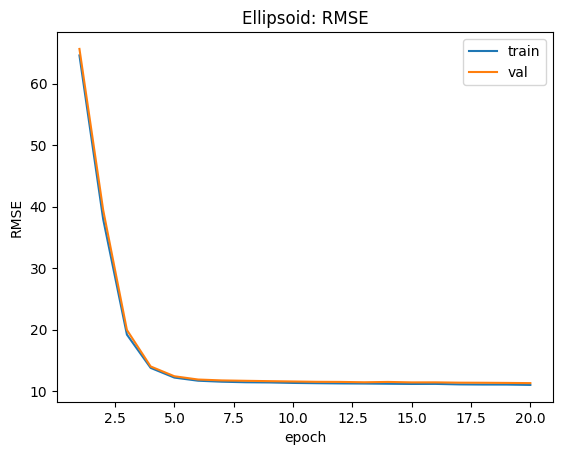

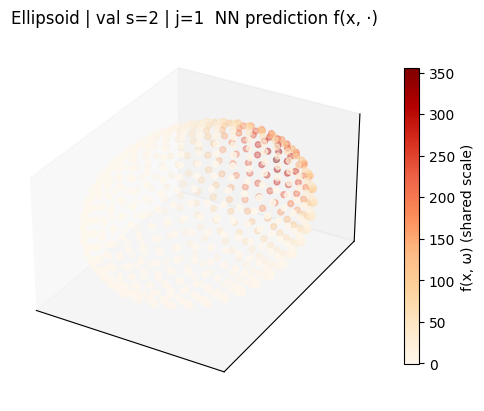

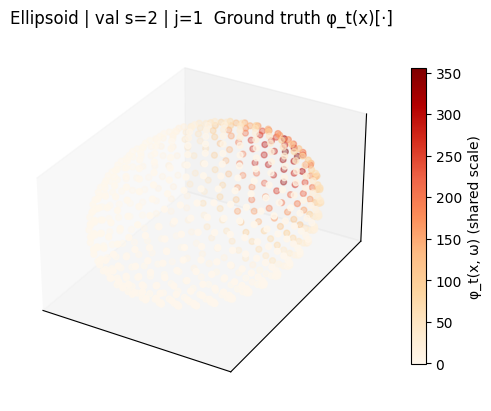

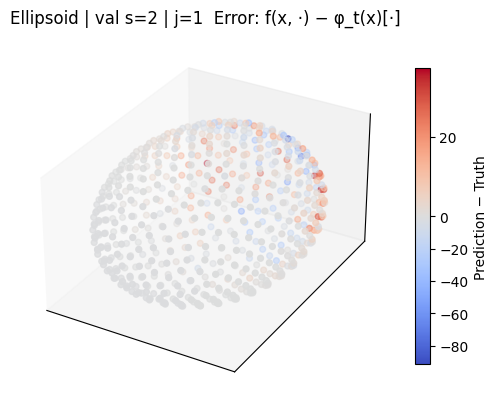

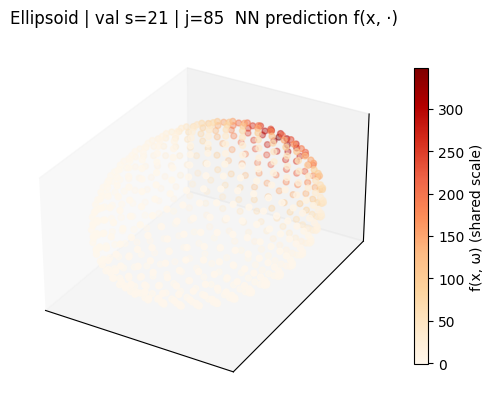

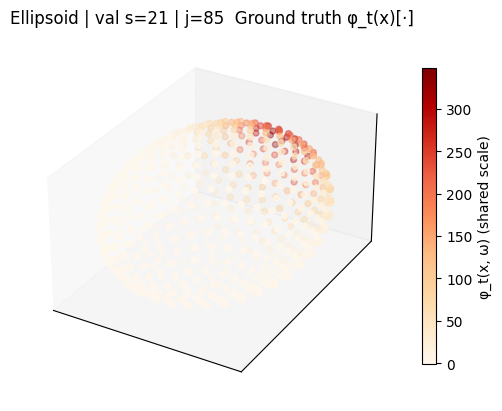

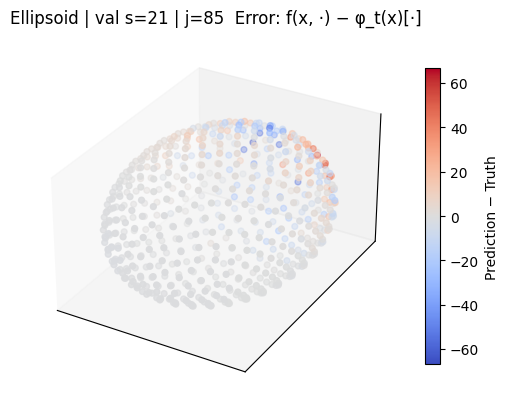

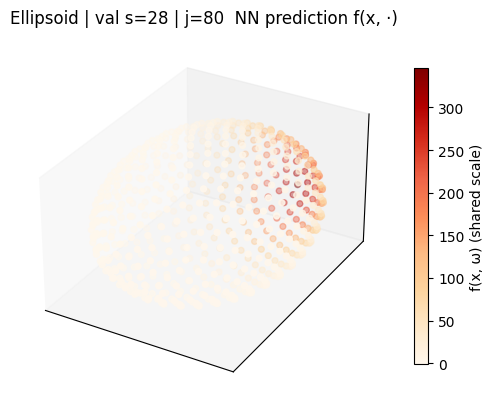

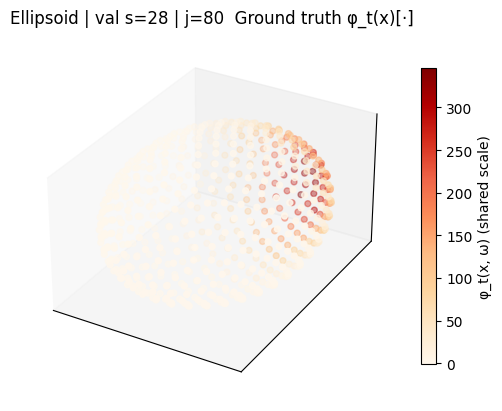

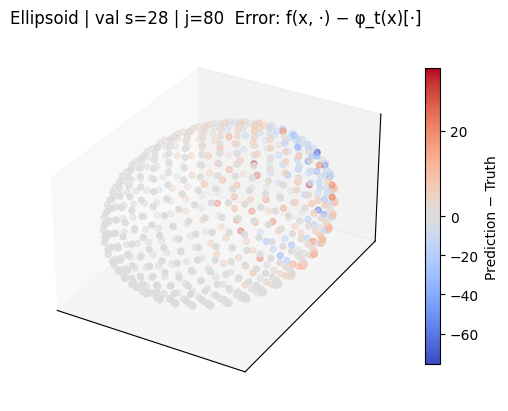

In [ ]:
# Build ellipsoid points
X_ell = fibonacci_sphere_scaled(CFG["N"], a=1.0, b=1.3, c=0.7)

# Signatures on the ellipsoid graph
out_ell = build_ggrf_signatures_from_coords(
    X_ell, k=CFG["k"], num_starts=CFG["num_starts"], start_mode=CFG["start_mode"],
    n_walks=CFG["n_walks"], phalt=CFG["phalt"], tau=CFG["t"], seed=CFG["seed"]
)
X_ell, phi_ell, start_indices_ell = out_ell["X"], out_ell["phi"], out_ell["start_indices"]

sup_ell = make_node_pair_supervision(
    {"X": X_ell, "phi": phi_ell, "start_indices": start_indices_ell,
     "params": {"N": X_ell.shape[0]}},
    mode=("all" if CFG["subsample_per_start"] is None else "random"),
    M_per_start=CFG["subsample_per_start"], seed=123
)
sup_ell["N"] = X_ell.shape[0]

# Graph geodesics (Dijkstra) from all start nodes (train+val) to all nodes
G_rows = geodesic_matrix_graph(X_ell, out_ell["neighbors"], sources=start_indices_ell)
# Assemble a full N x N geodesic matrix (only rows for starts are needed by the dataset)
G_full = np.zeros((X_ell.shape[0], X_ell.shape[0]), dtype=float)
for i, s in enumerate(start_indices_ell):
    G_full[s] = G_rows[i]

model_ell, hist_ell, splits_ell = train_model_node_pairs_by_start(
    sup_ell, G_full,
    batch_size=CFG["batch_size"], epochs=CFG["epochs"], lr=CFG["lr"],
    d_emb=CFG["d_emb"], hidden=CFG["hidden"], use_continuous_only=CFG["use_continuous_only"],
    val_frac=CFG["val_frac"], seed=CFG["torch_seed"]
)
plot_dynamics(hist_ell, title="Ellipsoid: RMSE")

# For plotting, pass geodesic rows so the MLP gets exactly the same geodesic feature we trained on
geod_rows_dict = {int(s): G_full[int(s)] for s in start_indices_ell}
visualize_several_validation_starts(
    model_ell, X_ell, start_indices_ell, phi_ell,
    val_start_ids=splits_ell["val_starts"], how_many=3,
    geod_rows=geod_rows_dict, title_prefix="Ellipsoid | val"
)


Epoch 01 | RMSE train: 73.997811 | RMSE val: 72.794481
Epoch 02 | RMSE train: 43.770390 | RMSE val: 42.851525
Epoch 03 | RMSE train: 33.121189 | RMSE val: 32.607341
Epoch 04 | RMSE train: 30.264292 | RMSE val: 29.622109
Epoch 05 | RMSE train: 29.384601 | RMSE val: 28.669119
Epoch 06 | RMSE train: 28.606354 | RMSE val: 27.608116
Epoch 07 | RMSE train: 28.187342 | RMSE val: 27.135756
Epoch 08 | RMSE train: 27.945024 | RMSE val: 26.947553
Epoch 09 | RMSE train: 27.772658 | RMSE val: 26.723933
Epoch 10 | RMSE train: 27.677540 | RMSE val: 26.640555
Epoch 11 | RMSE train: 27.549916 | RMSE val: 26.547691
Epoch 12 | RMSE train: 27.367995 | RMSE val: 26.364250
Epoch 13 | RMSE train: 27.227580 | RMSE val: 26.235304
Epoch 14 | RMSE train: 27.242006 | RMSE val: 26.200491
Epoch 15 | RMSE train: 27.097179 | RMSE val: 26.071853
Epoch 16 | RMSE train: 26.973437 | RMSE val: 26.004466
Epoch 17 | RMSE train: 26.878155 | RMSE val: 25.954332
Epoch 18 | RMSE train: 26.819901 | RMSE val: 25.928637
Epoch 19 |

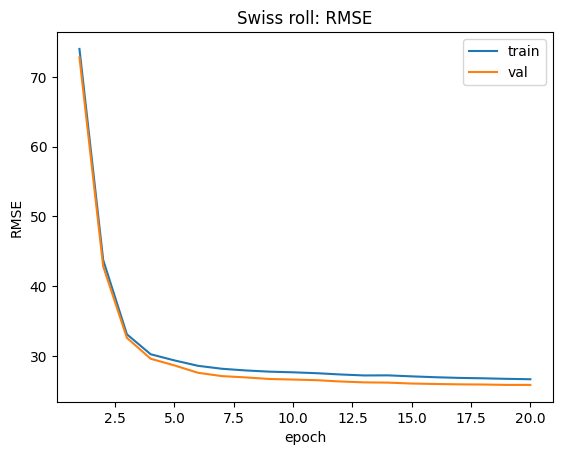

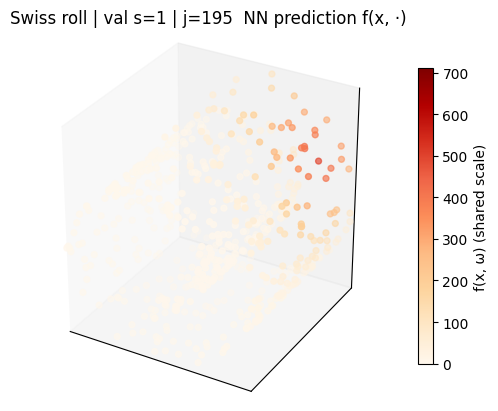

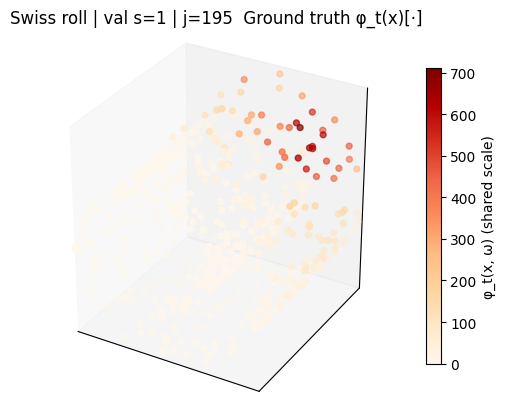

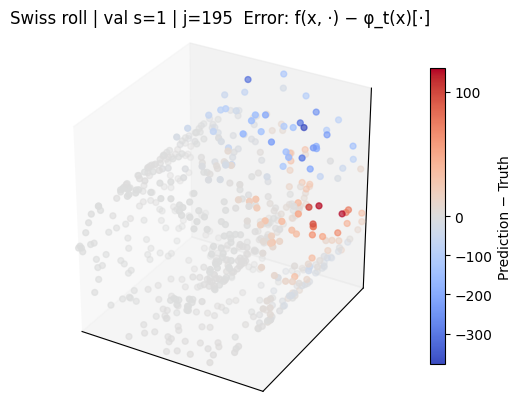

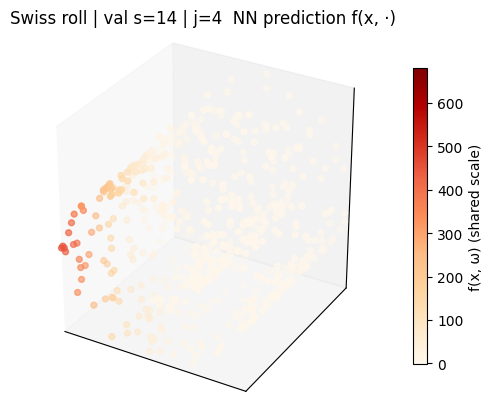

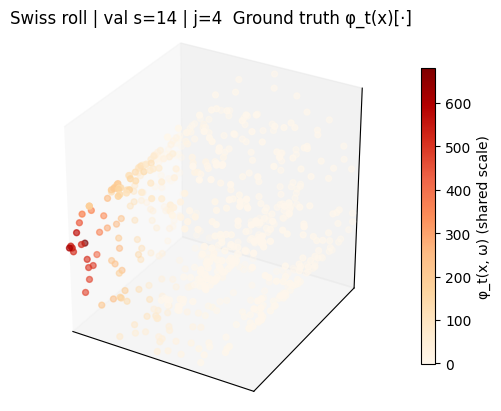

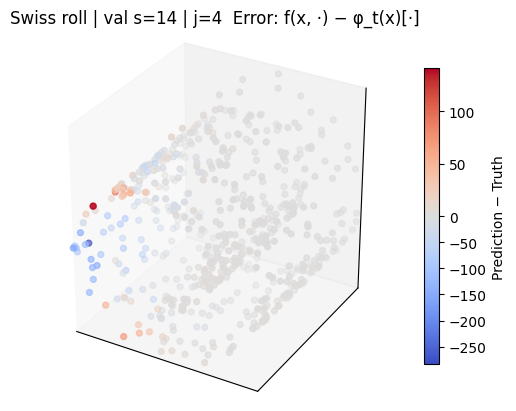

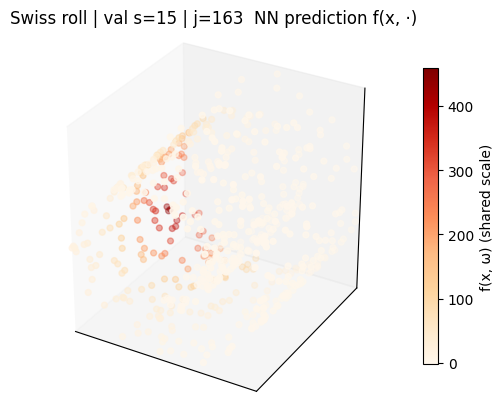

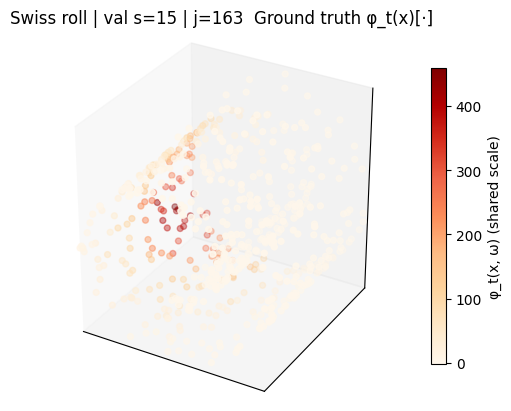

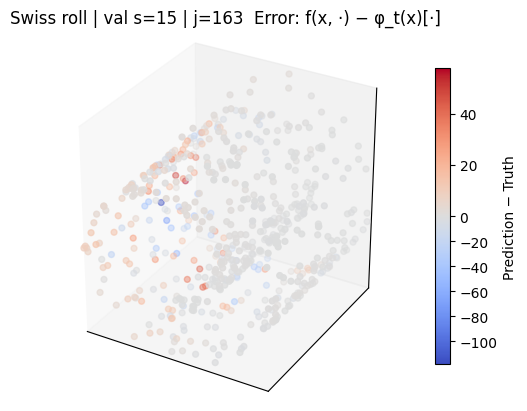

In [ ]:
X_sw = swiss_roll(CFG["N"], noise=0.0, seed=CFG["seed"])

out_sw = build_ggrf_signatures_from_coords(
    X_sw, k=CFG["k"], num_starts=CFG["num_starts"], start_mode=CFG["start_mode"],
    n_walks=CFG["n_walks"], phalt=CFG["phalt"], tau=CFG["t"], seed=CFG["seed"]
)
X_sw, phi_sw, start_indices_sw = out_sw["X"], out_sw["phi"], out_sw["start_indices"]

sup_sw = make_node_pair_supervision(
    {"X": X_sw, "phi": phi_sw, "start_indices": start_indices_sw,
     "params": {"N": X_sw.shape[0]}},
    mode=("all" if CFG["subsample_per_start"] is None else "random"),
    M_per_start=CFG["subsample_per_start"], seed=123
)
sup_sw["N"] = X_sw.shape[0]

# Graph geodesics from all start nodes
G_rows_sw = geodesic_matrix_graph(X_sw, out_sw["neighbors"], sources=start_indices_sw)
G_full_sw = np.zeros((X_sw.shape[0], X_sw.shape[0]), dtype=float)
for i, s in enumerate(start_indices_sw):
    G_full_sw[s] = G_rows_sw[i]

model_sw, hist_sw, splits_sw = train_model_node_pairs_by_start(
    sup_sw, G_full_sw,
    batch_size=CFG["batch_size"], epochs=CFG["epochs"], lr=CFG["lr"],
    d_emb=CFG["d_emb"], hidden=CFG["hidden"], use_continuous_only=CFG["use_continuous_only"],
    val_frac=CFG["val_frac"], seed=CFG["torch_seed"]
)
plot_dynamics(hist_sw, title="Swiss roll: RMSE")

geod_rows_sw = {int(s): G_full_sw[int(s)] for s in start_indices_sw}
visualize_several_validation_starts(
    model_sw, X_sw, start_indices_sw, phi_sw,
    val_start_ids=splits_sw["val_starts"], how_many=3,
    geod_rows=geod_rows_sw, title_prefix="Swiss roll | val"
)
